In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json 
import sys
#sys.modules.pop('../dataloader')
sys.path.append('../dataloader/')
sys.path.append('../utils/')


from dataloader import DataLoader 

import plotting

In [4]:
! ls ../utils

find_compatible_hits_dev.py  geometry.py  noise.py     __pycache__
find_compatible_hits.py      hits.py	  plotting.py


In [5]:
f = open("/home/lhv14/mapping_CMS_nocut_1000.json")
mappings = json.load(f)

In [3]:
md = pd.read_csv('/home/lhv14/new_md_hitbased.csv',  header=[0], index_col=[0, 1,2])
md = md.reset_index()
md.rename(columns = {'level_1':'volume_id', 'level_2':'layer_id'}, inplace = True)

In [7]:
dl = DataLoader() 
hits, allowed_pids = dl.load_data_cms(4)
hits

../dataloader/dataloader.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background = hits[hits['particle_id']==-1]
../dataloader/dataloader.py:121: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hits = hits[~hits['particle_id'].isin(forbidden_pids)]


run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     8025        1    52  5105  310104  310104    4649  -1.945225  -1.943862   
      5707        1    52  5105  310104  310104    2281  -0.711496   2.656365   
      8184        1    52  5105  310104  310104    4809  -1.944519  -1.944568   
      10622       1    52  5105  310104  310104    7315   2.656270  -0.711851   
      4643        1    52  5105  310104  310104    1202   1.944061   1.945026   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      205044      1    52  5105  310104  310104  203720  27.413033  20.850473   
      197095      1    52  5105  310104  310104  195678  34.383175  10.267204   
      197055      1    52  5105  310104  310104  195638  35.371029   7.527621   
      197116      1    52  5105  310104  310104  195699  34.792999  11.538926   
      197074      1    52  5105  310104  310104  195657  36.144032   6.563105   

                         z  particle_id  ...    sim_pt   sim_eta   sim_phi  \
entry subentry                           ...                                 
4     8025       -2.514950       -21684  ...  1.344249 -0.522033 -2.371882   
      5707       -0.525605       -19959  ...  0.814288  0.015682  1.746123   
      8184        5.445179        -2801  ...  0.153517  1.975594 -2.269836   
      10622       6.926171        -4616  ...  0.190140  1.226896 -0.211766   
      4643        8.124049       -20902  ...  1.012576  2.218619  1.257427   
...                    ...          ...  ...       ...       ...       ...   
      205044    224.132004            0  ...  0.003184  5.648093  2.976746   
      197095    186.378006            0  ...  0.003184  5.648093  2.976746   
      197055    187.453003            0  ...  0.003184  5.648093  2.976746   
      197116    185.977997            0  ...  0.003184  5.648093  2.976746   
      197074    187.852997            0  ...  0.003184  5.648093  2.976746   

                volume_id  layer_id  module_id          r  unique_layer_ids  \
entry subentry                                                                
4     8025              2         1          4   2.750000                 1   
      5707              2         1          5   2.750000                 1   
      8184              2         1          6   2.750000                 1   
      10622             2         1          7   2.750000                 1   
      4643              2         1          7   2.750000                 1   
...                   ...       ...        ...        ...               ...   
      205044            6         4          3  34.441494                43   
      197095            6         3          2  35.883400                42   
      197055            6         3          1  36.163170                42   
      197116            6         3          2  36.656509                42   
      197074            6         3          1  36.735069                42   

                unique_layer_id  discrete_module_id  
entry subentry                                       
4     8025                    1                 214  
      5707                    1                 215  
      8184                    1                 216  
      10622                   1                 217  
      4643                    1                 217  
...                         ...                 ...  
      205044                 43                6433  
      197095                 42                6422  
      197055                 42                6421  
      197116                 42                6422  
      197074                 42                6421  

[310104 rows x 27 columns]

In [6]:
len(allowed_pids)

13779

In [7]:
hits.particle_id.nunique()

22671

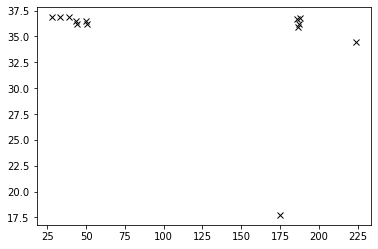

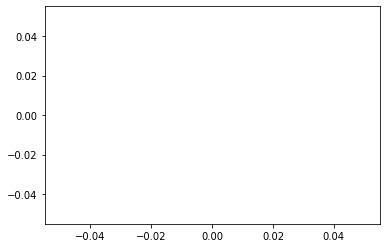

In [8]:
for pid in [0, 1]: 
    p = hits[hits['particle_id']==pid]
    plt.plot(p.z, p.r, "kx")
    plt.show()

In [9]:
def calc_distance(m, b, point_z, point_r): 
    d = np.abs(m*point_z - point_r +b )/np.sqrt(m**2+1)
    return d

In [10]:
def eval_line_at_point(m, b, z): 
    r = m * z +  b
    return r 

In [8]:
hits['z_2'] = hits.groupby('particle_id')['z'].shift(-1)


In [9]:
hits['diff_z'] = hits['z_2'] - hits['z']


In [10]:
z_0 = hits.groupby('particle_id').min().z
right = z_0[z_0 > 0]
left = z_0[z_0 < 0]

In [11]:
right_particles = hits[hits['particle_id'].isin(right.index)].reset_index()
left_particles = hits[hits['particle_id'].isin(left.index)].reset_index()

In [12]:
ix_right = np.where(right_particles['diff_z'] < 0)[0]
right_particles = right_particles.drop(ix_right + 1, axis = 0)

ix_left = np.where(left_particles['diff_z'] > 0)[0]
left_particles = left_particles.drop(ix_left + 1, axis = 0 )

In [13]:
f = right_particles.append(left_particles)

In [14]:
hits

,run,lumi,evt,nhit,hit_n,hit_id,x,y,z,particle_id,...,sim_eta,sim_phi,volume_id,layer_id,module_id,r,unique_layer_id,discrete_module_id,z_2,diff_z
1668,1,89,8805,136545,136545,750,1.945139,1.943948,-8.818335,-16156,...,-1.993133,0.768413,2,1,3,2.750000,1,213,-25.200001,-16.381666
1751,1,89,8805,136545,136545,835,1.944333,1.944754,-2.842576,-3029,...,0.007020,-0.066176,2,1,4,2.750000,1,214,-5.200835,-2.358260
8226,1,89,8805,136545,136545,7397,2.656227,-0.712008,-0.715824,-14699,...,0.176146,-0.284227,2,1,5,2.750000,1,215,-0.075086,0.640737
5657,1,89,8805,136545,136545,4804,-1.943937,-1.945150,0.912315,-10617,...,1.037463,-2.392608,2,1,5,2.750000,1,215,5.437775,4.525459
2048,1,89,8805,136545,136545,1135,1.944278,1.944809,10.710626,-11587,...,1.840821,0.819509,2,1,7,2.750000,1,217,24.799999,14.089374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130819,1,89,8805,136545,136545,130804,-21.959251,12.808491,230.968994,-6894,...,1.308712,3.027997,3,27,20,25.421764,43,32720,NaN,NaN
65243,1,89,8805,136545,136545,64791,23.471235,-9.765703,-175.199997,-17576,...,-2.624437,-0.316705,1,13,45,25.421799,17,11345,NaN,NaN
64975,1,89,8805,136545,136545,64523,-24.480110,-6.872338,-175.199997,-15286,...,-2.629861,-2.675143,1,13,27,25.426458,17,11327,NaN,NaN
79536,1,89,8805,136545,136545,79125,3.377235,25.205433,-265.200012,-7024,...,-3.017693,1.935381,1,16,11,25.430681,20,11611,NaN,NaN


In [156]:
hor_vol = [8, 13, 17]
ver_vol = [7, 9, 12, 14, 16, 18]


In [15]:
len(f)/len(hits)

0.8895821890219342

  0%|                                                                                                                               | 0/200 [00:00<?, ?it/s]

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     39327       1    52  5105  310104  310104   36502  4.251318  6.763046   
      39891       1    52  5105  310104  310104   37070 -7.012793 -3.996454   
      39650       1    52  5105  310104  310104   36828 -6.705299  4.359353   
      39890       1    52  5105  310104  310104   37069 -6.999249 -4.000554   
      39952       1    52  5105  310104  310104   37133 -5.842814 -5.468882   
      40440       1    52  5105  310104  310104   37626  8.000850 -0.369751   
      39640       1    52  5105  310104  310104   36818 -5.796907  5.648396   
      40392       1    52  5105  310104  310104   37577  7.579483 -2.843916   
      39171       1    52  5105  310104  310104   36343  8.046584  0.313965   
      39982       1    52  5105  310104  310104   37163 -5.237274 -6.178687   

                        z  parti

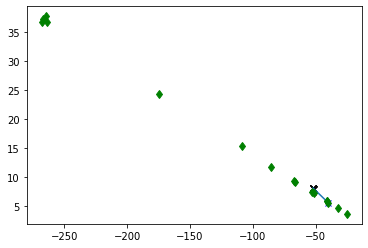

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     45800       1    52  5105  310104  310104   43034  9.005765 -2.183842   
      44933       1    52  5105  310104  310104   42158  9.167073  1.359423   
      39291       1    52  5105  310104  310104   36465  4.166799  5.930436   
      45843       1    52  5105  310104  310104   43077  8.938647 -2.174077   
      45806       1    52  5105  310104  310104   43040  8.833886 -2.808085   
      39061       1    52  5105  310104  310104   36232  7.312340 -0.559541   
      45832       1    52  5105  310104  310104   43066  8.760914 -2.797041   
      40304       1    52  5105  310104  310104   37487  6.026564 -4.033886   
      45017       1    52  5105  310104  310104   42243  7.138977  5.917520   
      45370       1    52  5105  310104  310104   42599 -9.206255  0.524898   

                        z  parti

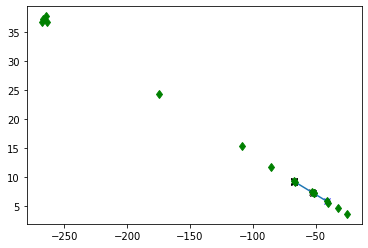

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     45726       1    52  5105  310104  310104   42956  7.329136 -7.393445   
      45778       1    52  5105  310104  310104   43010  8.241583 -6.232610   
      45767       1    52  5105  310104  310104   42999  7.262274 -7.335625   
      45542       1    52  5105  310104  310104   42772 -5.146258 -8.967472   
      45784       1    52  5105  310104  310104   43016  8.393669 -6.042065   
      45571       1    52  5105  310104  310104   42801 -5.187088 -9.045102   
      45093       1    52  5105  310104  310104   42320  4.085101  9.594460   
      45022       1    52  5105  310104  310104   42248  8.509289  6.039398   
      45222       1    52  5105  310104  310104   42450 -4.797468  9.174768   
      44972       1    52  5105  310104  310104   42198  9.857352  3.177899   

                        z  parti

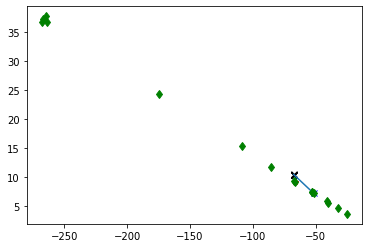

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     45001       1    52  5105  310104  310104   42227   8.065649   4.662773   
      49659       1    52  5105  310104  310104   46926  -2.817669  11.509667   
      49469       1    52  5105  310104  310104   46736  11.828518   0.514584   
      50123       1    52  5105  310104  310104   47394  -1.132212 -11.731562   
      50271       1    52  5105  310104  310104   47545   5.838169 -10.316818   
      45787       1    52  5105  310104  310104   43019   7.652858  -5.297154   
      50318       1    52  5105  310104  310104   47592  11.092533  -4.183343   
      45779       1    52  5105  310104  310104   43011   7.432515  -5.600756   
      49507       1    52  5105  310104  310104   46774  10.415003   5.557434   
      50332       1    52  5105  310104  310104   47606  11.371060  -3.180178   

        

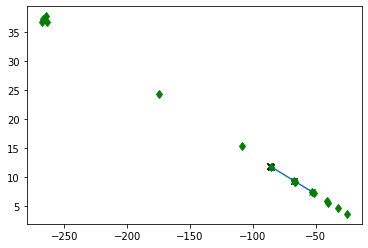

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     50398       1    52  5105  310104  310104   47673  13.282549   0.839711   
      915         1    52  5105  310104  310104   48423  11.118227  -7.160329   
      45649       1    52  5105  310104  310104   42879   1.937523  -9.247974   
      45662       1    52  5105  310104  310104   42892   1.256806  -9.402738   
      45479       1    52  5105  310104  310104   42709  -7.203995  -6.112364   
      51143       1    52  5105  310104  310104   48427  11.359818  -6.708344   
      51084       1    52  5105  310104  310104   48363   7.457416 -10.931059   
      45816       1    52  5105  310104  310104   43050   8.846526  -3.443814   
      51043       1    52  5105  310104  310104   48322   3.485261 -12.716612   
      45749       1    52  5105  310104  310104   42980   4.925578  -8.051551   

        

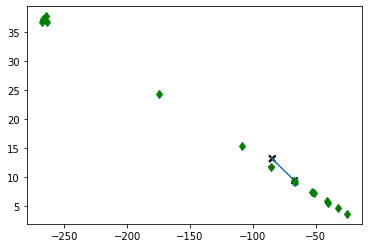

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     49739       1    52  5105  310104  310104   47006  -7.376303   9.224901   
      55758       1    52  5105  310104  310104   53068   6.414308 -13.265183   
      55530       1    52  5105  310104  310104   52839 -13.104895  -6.735424   
      50004       1    52  5105  310104  310104   47273  -9.449719  -7.099759   
      55637       1    52  5105  310104  310104   52947  -3.912825 -14.229447   
      55572       1    52  5105  310104  310104   52881 -10.857840  -9.866477   
      55252       1    52  5105  310104  310104   52561   5.606256  13.611131   
      55543       1    52  5105  310104  310104   52852 -12.312377  -8.054302   
      55852       1    52  5105  310104  310104   53162  13.577968  -5.681091   
      55517       1    52  5105  310104  310104   52826 -12.116247  -8.351437   

        

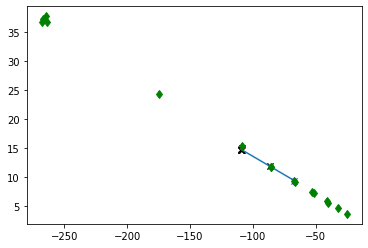

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     55122       1    52  5105  310104  310104   52431  12.675393   8.685817   
      55847       1    52  5105  310104  310104   53157  14.468268  -5.194855   
      55124       1    52  5105  310104  310104   52433  13.104911   8.052150   
      64542       1    52  5105  310104  310104   61892  24.522642   6.450631   
      55759       1    52  5105  310104  310104   53069   6.695267 -13.796124   
      64591       1    52  5105  310104  310104   61941  19.890192  15.819193   
      55840       1    52  5105  310104  310104   53150  14.640550  -4.523456   
      64798       1    52  5105  310104  310104   62149 -24.414974   6.690470   
      65062       1    52  5105  310104  310104   62415  10.296403 -23.120222   
      55078       1    52  5105  310104  310104   52387  15.380720   1.292548   

        

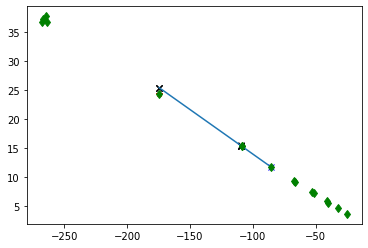

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     169107      1    52  5105  310104  310104  167366  17.391464  32.358570   
      169328      1    52  5105  310104  310104  167589 -27.694984  24.138205   
      169846      1    52  5105  310104  310104  168111  14.512180 -33.752617   
      169043      1    52  5105  310104  310104  167302  24.428179  27.716208   
      3029        1    52  5105  310104  310104  167588 -27.599525  24.233664   
      169025      1    52  5105  310104  310104  167284  29.799469  21.464247   
      168932      1    52  5105  310104  310104  167191  36.724003   1.415710   
      169944      1    52  5105  310104  310104  168212  27.461639 -24.371550   
      169024      1    52  5105  310104  310104  167283  29.876614  21.341471   
      65154       1    52  5105  310104  310104   62507  24.142282  -3.179774   

        

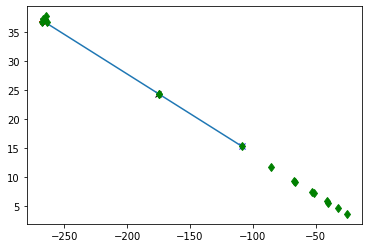

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     176226      1    52  5105  310104  310104  174546 -68.602730 -28.435625   
      175940      1    52  5105  310104  310104  174258  35.985222  64.961433   
      175941      1    52  5105  310104  310104  174259  36.032486  64.935310   
      176436      1    52  5105  310104  310104  174756  55.286266 -49.581898   
      176417      1    52  5105  310104  310104  174737  43.113007 -60.466660   
      176271      1    52  5105  310104  310104  174591 -49.293335 -55.544144   
      175973      1    52  5105  310104  310104  174293  20.234222  71.453545   
      175972      1    52  5105  310104  310104  174292  20.147739  71.478462   
      175910      1    52  5105  310104  310104  174226  49.132275  55.688076   
      176198      1    52  5105  310104  310104  174518 -73.131088 -12.922964   

        

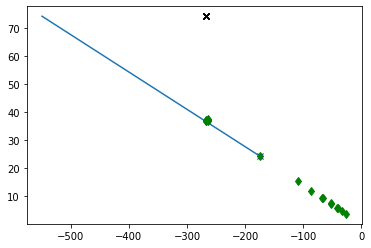

  2%|█▊                                                                                                                     | 3/200 [00:01<01:26,  2.27it/s]

pid -22480.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     24509       1    52  5105  310104  310104   21479   4.233249 -14.304571   
      22713       1    52  5105  310104  310104   19651  -9.972425  11.099356   
      24202       1    52  5105  310104  310104   21168  -2.132568 -14.753998   
      21841       1    52  5105  310104  310104   18765   9.308107  11.748558   
      22703       1    52  5105  310104  310104   19641 -11.213431   9.858350   
      24756       1    52  5105  310104  310104   21732  10.234475 -10.837306   
      23918       1    52  5105  310104  310104   20880  -6.562914 -13.473478   
      245662      1    52  5105  310104  310104  244862 -10.263185  20.032652   
      250022      1    52  5105  310104  310104  249264  21.521839  -6.564286   
      23765       1    52  5105  310104  310104   20726  -9.639413 -10.725263   

        

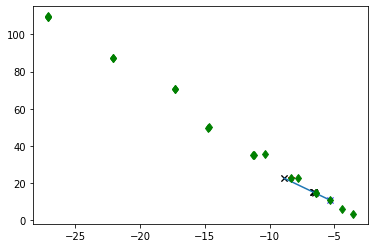

pid -22480.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     270135      1    52  5105  310104  310104  269638 -17.686365 -30.476366   
      246832      1    52  5105  310104  310104  246048 -24.010677   6.155254   
      247600      1    52  5105  310104  310104  246818 -19.914766 -14.936111   
      268577      1    52  5105  310104  310104  268077 -33.548927   9.549968   
      243679      1    52  5105  310104  310104  242845  24.927481   0.955801   
      247598      1    52  5105  310104  310104  246816 -22.192266 -10.991365   
      271139      1    52  5105  310104  310104  270647  18.229950 -29.683434   
      271158      1    52  5105  310104  310104  270666  18.474560 -30.062702   
      266407      1    52  5105  310104  310104  265884  24.287844  24.915375   
      266406      1    52  5105  310104  310104  265883  24.246675  24.951847   

        

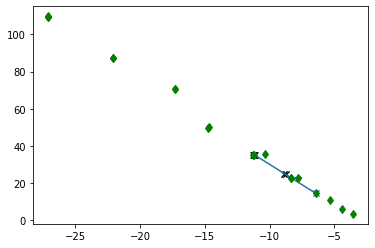

  2%|██▍                                                                                                                    | 4/200 [00:01<01:12,  2.69it/s]

pid -22477.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     233985      1    52  5105  310104  310104  232970  21.489040 -14.240577   
      22465       1    52  5105  310104  310104   19400  -4.906395  14.069028   
      233497      1    52  5105  310104  310104  232452 -15.311037  20.741093   
      233341      1    52  5105  310104  310104  232296  15.277609  20.769142   
      233593      1    52  5105  310104  310104  232548 -25.082758   5.923751   
      233986      1    52  5105  310104  310104  232971  21.554041 -14.127994   
      233227      1    52  5105  310104  310104  232182  25.586575   3.066467   
      233729      1    52  5105  310104  310104  232707 -12.747068 -22.382143   
      233760      1    52  5105  310104  310104  232738  -7.140028 -24.782900   
      22911       1    52  5105  310104  310104   19851 -13.072290   6.261606   

        

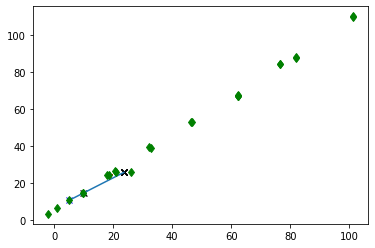

pid -22477.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     258399      1    52  5105  310104  310104  257734  11.367320  36.645580   
      258458      1    52  5105  310104  310104  257793 -12.765478  36.047291   
      258655      1    52  5105  310104  310104  257996 -14.357532 -35.442211   
      232981      1    52  5105  310104  310104  231930 -10.409910 -22.890274   
      258332      1    52  5105  310104  310104  257667  34.268806  16.956648   
      233190      1    52  5105  310104  310104  232145  27.378805   3.311407   
      258709      1    52  5105  310104  310104  258051   3.897856 -38.054802   
      258409      1    52  5105  310104  310104  257744   5.579818  37.818394   
      232921      1    52  5105  310104  310104  231868 -20.898039 -13.943977   
      258535      1    52  5105  310104  310104  257872 -35.146511  15.336920   

        

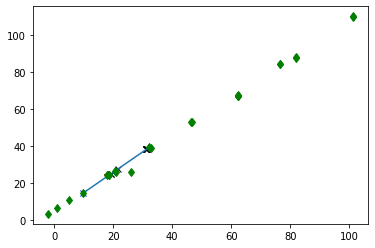

  4%|████▏                                                                                                                  | 7/200 [00:01<00:41,  4.67it/s]

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     232456      1    52  5105  310104  310104  231398  27.260052   1.513471   
      1822        1    52  5105  310104  310104  249576  21.363892  -4.871478   
      23365       1    52  5105  310104  310104   20312 -14.683655  -2.756882   
      25069       1    52  5105  310104  310104   22058  13.888853  -5.421305   
      232672      1    52  5105  310104  310104  231614  -6.439034  25.195976   
      21421       1    52  5105  310104  310104   18342  13.904121   3.863799   
      1354        1    52  5105  310104  310104   20447 -13.832448  -4.068627   
      232592      1    52  5105  310104  310104  231534  11.093930  23.501732   
      245213      1    52  5105  310104  310104  244411   5.302918  21.359694   
      23960       1    52  5105  310104  310104   20923  -6.569252 -13.469496   

        

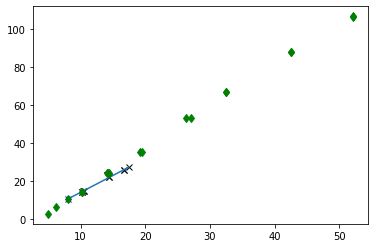

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     267128      1    52  5105  310104  310104  266622  12.291750  33.228695   
      249917      1    52  5105  310104  310104  249156  19.380489 -14.962508   
      246296      1    52  5105  310104  310104  245503 -16.460987  17.863626   
      244844      1    52  5105  310104  310104  244024  14.059696  19.878550   
      246297      1    52  5105  310104  310104  245504 -14.024966  19.907690   
      267937      1    52  5105  310104  310104  267435 -15.100180  34.521580   
      247088      1    52  5105  310104  310104  246304 -24.048954   3.349613   
      272322      1    52  5105  310104  310104  271841  35.275040  -1.550668   
      244846      1    52  5105  310104  310104  244026  15.442407  18.718317   
      270258      1    52  5105  310104  310104  269761 -20.139076 -29.189075   

        

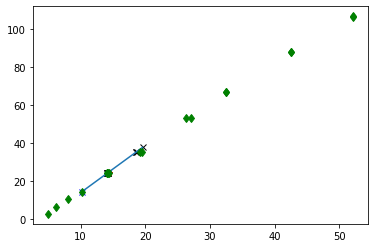

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     258840      1    52  5105  310104  310104  258182  36.318287 -11.525574   
      258796      1    52  5105  310104  310104  258138  26.817013 -27.070074   
      232645      1    52  5105  310104  310104  231587  -3.156819  26.572275   
      258650      1    52  5105  310104  310104  257990 -15.876428 -33.645267   
      258391      1    52  5105  310104  310104  257726  19.192812  32.893635   
      258694      1    52  5105  310104  310104  258036  -6.850247 -37.495388   
      258728      1    52  5105  310104  310104  258070  11.369093 -36.381592   
      233009      1    52  5105  310104  310104  231958  -3.526819 -25.771463   
      258797      1    52  5105  310104  310104  258139  27.011625 -26.897661   
      258480      1    52  5105  310104  310104  257815 -15.557205  34.801746   

        

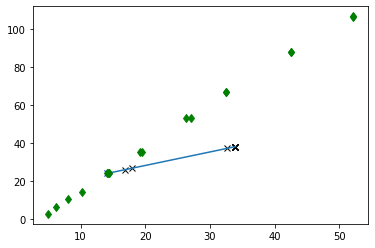

  4%|████▊                                                                                                                  | 8/200 [00:02<00:47,  4.03it/s]

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     91452       1    52  5105  310104  310104   89046  6.490555  -7.058582   
      90974       1    52  5105  310104  310104   88567 -6.516107   6.818476   
      89580       1    52  5105  310104  310104   87148  6.165185   6.712303   
      90457       1    52  5105  310104  310104   88045  4.790154  -7.757801   
      241028      1    52  5105  310104  310104  240168 -2.475730 -26.676825   
      89887       1    52  5105  310104  310104   87457 -7.293843   5.441952   
      89403       1    52  5105  310104  310104   86971  9.053889   1.117803   
      91010       1    52  5105  310104  310104   88604 -6.627337   6.946107   
      84043       1    52  5105  310104  310104   81530  0.442134   6.003078   
      84564       1    52  5105  310104  310104   82057 -4.767390  -3.743853   

                    

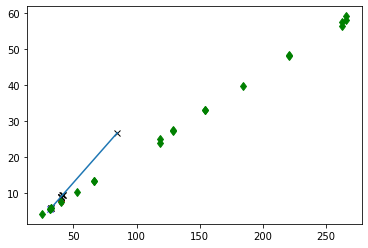

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     89866       1    52  5105  310104  310104   87436  -5.254049   5.608012   
      243345      1    52  5105  310104  310104  242509  -3.760727 -23.816734   
      243599      1    52  5105  310104  310104  242765  24.115513  -0.389254   
      243226      1    52  5105  310104  310104  242390 -18.232117 -15.791977   
      242877      1    52  5105  310104  310104  242037  -4.555494  23.687176   
      243149      1    52  5105  310104  310104  242313 -20.511589 -13.165341   
      243133      1    52  5105  310104  310104  242297 -24.103609  -0.456760   
      242735      1    52  5105  310104  310104  241895  11.642143  21.107845   
      95405       1    52  5105  310104  310104   93048  -9.289718   4.192940   
      95406       1    52  5105  310104  310104   93049  -9.282140   4.209690   

        

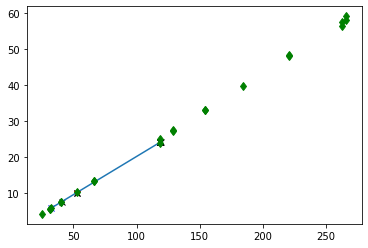

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     100965      1    52  5105  310104  310104   98660 -12.702582  -5.186964   
      243310      1    52  5105  310104  310104  242474  -2.545727 -25.548687   
      100992      1    52  5105  310104  310104   98687 -12.618691  -5.138963   
      100641      1    52  5105  310104  310104   98336   6.602843  12.023743   
      242816      1    52  5105  310104  310104  241976 -12.184909  22.603334   
      100699      1    52  5105  310104  310104   98394   0.875055  13.679408   
      95530       1    52  5105  310104  310104   93173  -9.902220  -3.513083   
      243433      1    52  5105  310104  310104  242597  12.724391 -22.306240   
      100659      1    52  5105  310104  310104   98354   2.851676  13.306364   
      100798      1    52  5105  310104  310104   98493  -9.596983   9.776772   

        

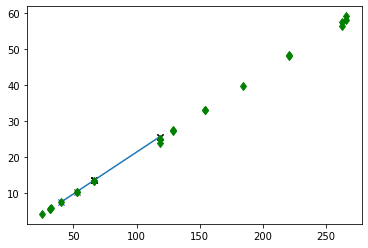

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     242964      1    52  5105  310104  310104  242126 -22.563080  10.042737   
      178127      1    52  5105  310104  310104  176456   0.524011  27.184259   
      178164      1    52  5105  310104  310104  176493   6.929025  26.392597   
      178165      1    52  5105  310104  310104  176494   6.746303  26.421537   
      100849      1    52  5105  310104  310104   98544 -12.380748   5.329268   
      243047      1    52  5105  310104  310104  242211 -24.976721  -0.404713   
      179111      1    52  5105  310104  310104  177444  26.941402  -0.181798   
      100591      1    52  5105  310104  310104   98286  10.727792   8.154456   
      242782      1    52  5105  310104  310104  241942   4.724274  24.526989   
      178062      1    52  5105  310104  310104  176389   9.250927  25.347757   

        

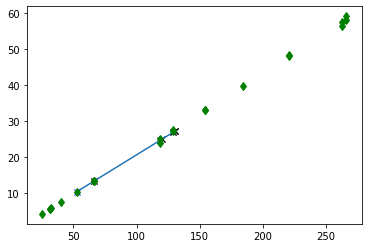

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     180461      1    52  5105  310104  310104  178798  -5.149262  32.294018   
      241342      1    52  5105  310104  310104  240489  24.166502   0.713030   
      241518      1    52  5105  310104  310104  240666  10.728895  21.332474   
      180985      1    52  5105  310104  310104  179324  22.488577 -23.763651   
      242439      1    52  5105  310104  310104  241598  23.739635  -2.749849   
      180363      1    52  5105  310104  310104  178700  21.710985  23.990496   
      242168      1    52  5105  310104  310104  241327   2.674272 -23.715466   
      180463      1    52  5105  310104  310104  178800  -1.357666  32.645226   
      180462      1    52  5105  310104  310104  178799  -6.041563  32.176544   
      242373      1    52  5105  310104  310104  241532  22.903818  -7.893742   

        

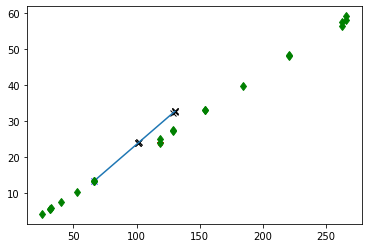

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     178137      1    52  5105  310104  310104  176466   7.761155  24.998308   
      242700      1    52  5105  310104  310104  241860   6.712953  22.944223   
      243153      1    52  5105  310104  310104  242317 -22.558092  -8.492558   
      243317      1    52  5105  310104  310104  242481  -3.205727 -23.715466   
      243151      1    52  5105  310104  310104  242315 -20.107340 -13.301453   
      178142      1    52  5105  310104  310104  176471  -0.657146  26.183107   
      1447        1    52  5105  310104  310104  176676 -16.910215  19.724493   
      178401      1    52  5105  310104  310104  176732 -24.851774   8.285543   
      242643      1    52  5105  310104  310104  241802  15.900424  18.071533   
      242831      1    52  5105  310104  310104  241991  -5.371280  23.282486   

        

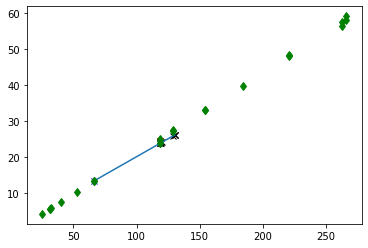

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     243347      1    52  5105  310104  310104  242511   6.915060 -26.993452   
      243348      1    52  5105  310104  310104  242512   7.460082 -26.795080   
      242502      1    52  5105  310104  310104  241661  27.582716   3.265018   
      243134      1    52  5105  310104  310104  242298 -22.355074 -16.741152   
      242738      1    52  5105  310104  310104  241898  -0.480726  27.730637   
      242997      1    52  5105  310104  310104  242161 -28.055290   0.584910   
      264812      1    52  5105  310104  310104  264272  30.356544  21.592730   
      264811      1    52  5105  310104  310104  264271  31.577883  19.823315   
      265452      1    52  5105  310104  310104  264919  28.831432 -20.199911   
      265225      1    52  5105  310104  310104  264685 -28.650883 -20.461487   

        

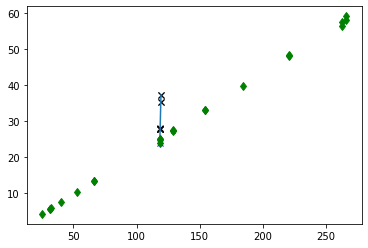

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     190087      1    52  5105  310104  310104  188575 -32.309772   3.905678   
      190256      1    52  5105  310104  310104  188744 -19.561102 -26.009981   
      190330      1    52  5105  310104  310104  188818  -4.971481 -32.169456   
      190129      1    52  5105  310104  310104  188617 -32.102798  -6.601727   
      190366      1    52  5105  310104  310104  188855   1.986551 -32.710396   
      189833      1    52  5105  310104  310104  188319   3.117479  32.413540   
      179106      1    52  5105  310104  310104  177439  27.222971  -2.155140   
      190402      1    52  5105  310104  310104  188892  13.557767 -29.608641   
      190524      1    52  5105  310104  310104  189014  31.054865 -10.449619   
      189547      1    52  5105  310104  310104  188033  33.218006   0.412718   

        

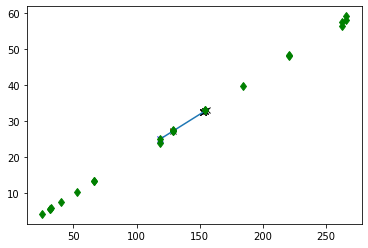

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     191416      1    52  5105  310104  310104  189906  41.132187  -0.174189   
      178608      1    52  5105  310104  310104  176939 -21.357069 -18.182152   
      191683      1    52  5105  310104  310104  190173 -15.584085  38.065487   
      179746      1    52  5105  310104  310104  178083 -29.030132  -6.671261   
      180102      1    52  5105  310104  310104  178439  20.340149 -21.768677   
      179339      1    52  5105  310104  310104  177672  20.647308  20.608429   
      178497      1    52  5105  310104  310104  176828 -26.874107  -8.108866   
      179338      1    52  5105  310104  310104  177671  17.596972  23.318857   
      180222      1    52  5105  310104  310104  178559  29.200184  -0.883945   
      179419      1    52  5105  310104  310104  177752   1.498641  29.119259   

        

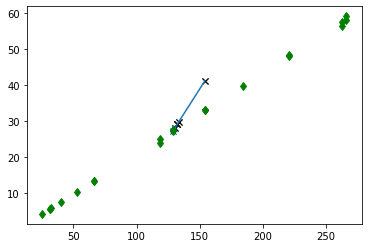

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     199005      1    52  5105  310104  310104  197598  33.953121 -18.045010   
      199006      1    52  5105  310104  310104  197599  31.101427 -22.583450   
      198831      1    52  5105  310104  310104  197424  -8.939392 -37.584881   
      198637      1    52  5105  310104  310104  197228 -37.894131  -7.504974   
      198422      1    52  5105  310104  310104  197011  -4.076679  38.280403   
      198275      1    52  5105  310104  310104  196864  28.711681  25.522631   
      198477      1    52  5105  310104  310104  197066 -20.790241  32.401428   
      198961      1    52  5105  310104  310104  197554  25.117237 -29.324539   
      198964      1    52  5105  310104  310104  197557  30.095270 -24.346508   
      198962      1    52  5105  310104  310104  197555  25.212696 -29.229080   

        

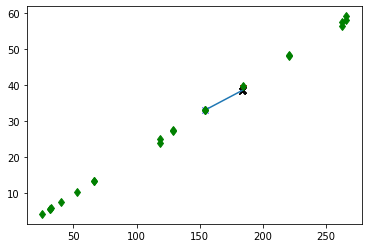

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     218610      1    52  5105  310104  310104  217392 -50.565975 -28.659327   
      218330      1    52  5105  310104  310104  217110  50.592335  28.611055   
      218383      1    52  5105  310104  310104  217163  26.372980  51.814419   
      218678      1    52  5105  310104  310104  217460  -7.895715 -57.607101   
      218745      1    52  5105  310104  310104  217527  18.547869 -55.108437   
      218490      1    52  5105  310104  310104  217272 -31.097031  49.133251   
      217839      1    52  5105  310104  310104  216617 -13.973553  55.719421   
      218679      1    52  5105  310104  310104  217461  -8.428260 -57.491253   
      218108      1    52  5105  310104  310104  216888  -5.458878 -57.189949   
      218049      1    52  5105  310104  310104  216829 -39.666382 -41.469948   

        

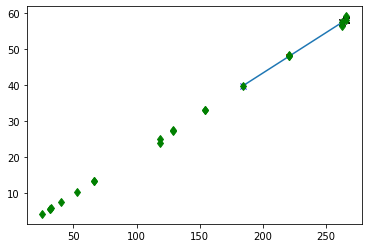

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     208568      1    52  5105  310104  310104  207263   9.164036  49.037331   
      208481      1    52  5105  310104  310104  207176  47.312290  15.601963   
      208604      1    52  5105  310104  310104  207299  -0.096182  49.919827   
      208723      1    52  5105  310104  310104  207418 -46.206390  18.947922   
      208551      1    52  5105  310104  310104  207246  22.957323  45.469833   
      208637      1    52  5105  310104  310104  207332 -18.449482  46.438816   
      208534      1    52  5105  310104  310104  207229  31.127615  39.102489   
      208503      1    52  5105  310104  310104  207198  47.975002  17.411411   
      208927      1    52  5105  310104  310104  207622  -0.082494 -51.025478   
      208936      1    52  5105  310104  310104  207631   0.333111 -50.046360   

        

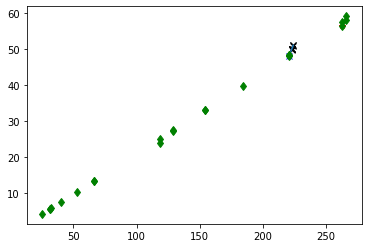

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     217999      1    52  5105  310104  310104  216779 -55.816677  -8.541159   
      217713      1    52  5105  310104  310104  216491  45.039433  34.357632   
      217758      1    52  5105  310104  310104  216536  21.986353  51.956165   
      217817      1    52  5105  310104  310104  216595  -8.629800  56.057472   
      217778      1    52  5105  310104  310104  216556  12.168526  55.247559   
      217777      1    52  5105  310104  310104  216555  12.338691  55.206707   
      217665      1    52  5105  310104  310104  216443  56.365814   4.711914   
      218134      1    52  5105  310104  310104  216914   8.502050 -55.675198   
      217740      1    52  5105  310104  310104  216518  31.804508  46.675304   
      217913      1    52  5105  310104  310104  216691 -48.881908  29.045956   

        

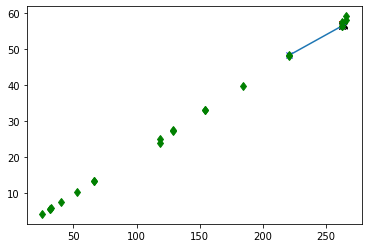

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     219773      1    52  5105  310104  310104  218557  50.442730 -39.353607   
      218976      1    52  5105  310104  310104  217760  32.824734  54.916279   
      219120      1    52  5105  310104  310104  217904 -25.908485  58.498337   
      219700      1    52  5105  310104  310104  218484  25.760757 -58.564823   
      219150      1    52  5105  310104  310104  217934 -39.959309  49.968201   
      219151      1    52  5105  310104  310104  217935 -40.005360  49.932121   
      219152      1    52  5105  310104  310104  217936 -40.054951  49.893269   
      219153      1    52  5105  310104  310104  217937 -40.150593  49.818336   
      219296      1    52  5105  310104  310104  218080 -63.094498  10.633808   
      219416      1    52  5105  310104  310104  218200 -54.271446 -33.891422   

        

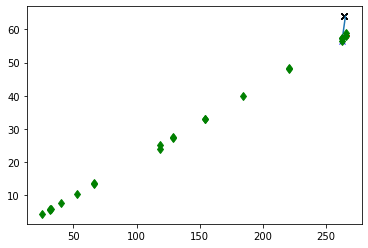

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     218601      1    52  5105  310104  310104  217383 -55.478287 -17.976046   
      218815      1    52  5105  310104  310104  217597  57.460155  -9.951481   
      218474      1    52  5105  310104  310104  217256 -28.440073  51.019993   
      218315      1    52  5105  310104  310104  217095  53.988407  21.550776   
      218501      1    52  5105  310104  310104  217283 -42.829975  39.980362   
      218666      1    52  5105  310104  310104  217448 -18.983841 -54.789257   
      218816      1    52  5105  310104  310104  217598  56.391220 -13.485015   
      218371      1    52  5105  310104  310104  217151  34.306496  47.646931   
      218665      1    52  5105  310104  310104  217447 -20.258093 -54.313984   
      218634      1    52  5105  310104  310104  217416 -33.529972 -48.228230   

        

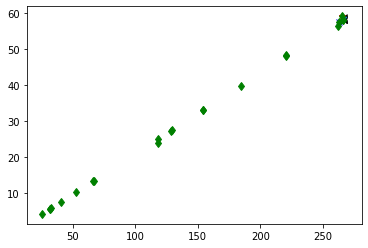

  4%|█████▎                                                                                                                 | 9/200 [00:04<02:25,  1.31it/s]

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     83696       1    52  5105  310104  310104   81181  15.753487  -1.593409   
      2016        1    52  5105  310104  310104   81087   8.759868 -13.156034   
      83375       1    52  5105  310104  310104   80845 -14.286334   6.750355   
      236234      1    52  5105  310104  310104  235278 -10.093185 -24.255365   
      235990      1    52  5105  310104  310104  235028 -23.517555  10.155719   
      236175      1    52  5105  310104  310104  235219 -14.073721 -21.406393   
      83570       1    52  5105  310104  310104   81042   3.463539 -15.391014   
      236082      1    52  5105  310104  310104  235124 -24.526098  -7.435543   
      236277      1    52  5105  310104  310104  235321  -0.246332 -25.571707   
      83214       1    52  5105  310104  310104   80684  11.386274  11.100548   

        

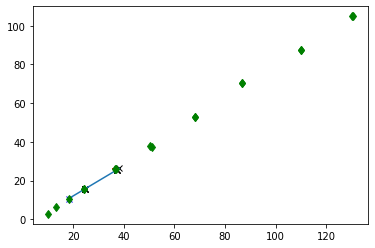

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     260138      1    52  5105  310104  310104  259520  -5.143136  36.689255   
      260137      1    52  5105  310104  310104  259519  -9.177032  35.818764   
      236355      1    52  5105  310104  310104  235399   6.868670 -26.250227   
      236383      1    52  5105  310104  310104  235428  16.165297 -20.480587   
      236274      1    52  5105  310104  310104  235318  -1.061332 -26.079891   
      235778      1    52  5105  310104  310104  234815  19.329670  19.047844   
      260186      1    52  5105  310104  310104  259568 -27.210726  25.129808   
      685         1    52  5105  310104  310104  234814  19.379463  19.006063   
      235973      1    52  5105  310104  310104  235011 -15.574264  22.199005   
      260472      1    52  5105  310104  310104  259859   9.729116 -36.332264   

        

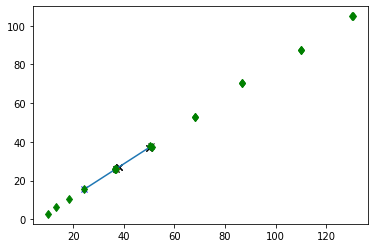

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     259457      1    52  5105  310104  310104  258815  38.083755   0.324382   
      259498      1    52  5105  310104  310104  258856  30.888962  22.082397   
      236079      1    52  5105  310104  310104  235121 -26.405418  -0.435538   
      259859      1    52  5105  310104  310104  259239  -1.431627 -36.974140   
      259599      1    52  5105  310104  310104  258959  -3.416528  37.845181   
      259907      1    52  5105  310104  310104  259289  15.968223 -33.376400   
      259499      1    52  5105  310104  310104  258857  29.284693  24.195042   
      236128      1    52  5105  310104  310104  235172 -21.605553 -16.846050   
      236484      1    52  5105  310104  310104  235540  25.193758  -7.307195   
      236328      1    52  5105  310104  310104  235372  12.725594 -24.243643   

        

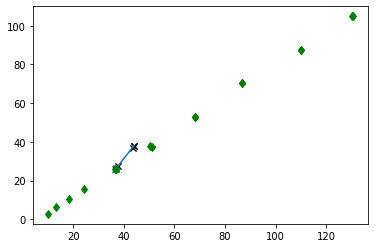

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     279501      1    52  5105  310104  310104  279159 -53.201370  -0.358673   
      279489      1    52  5105  310104  310104  279147 -49.802658  18.718716   
      66          1    52  5105  310104  310104  279275   8.606738 -52.504486   
      279390      1    52  5105  310104  310104  279048  30.941526  44.281982   
      279592      1    52  5105  310104  310104  279254  -9.963461 -52.265259   
      1363        1    52  5105  310104  310104  279185 -50.278973 -17.410049   
      279662      1    52  5105  310104  310104  279326  41.602238 -33.187019   
      279462      1    52  5105  310104  310104  279120 -33.089714  42.645287   
      279685      1    52  5105  310104  310104  279349  50.505508 -16.787647   
      279511      1    52  5105  310104  310104  279169 -53.289658  -9.509448   

        

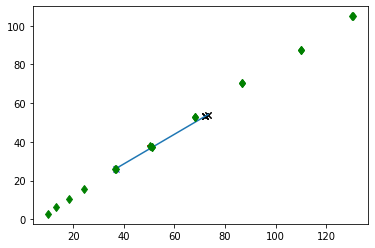

  6%|███████                                                                                                               | 12/200 [00:05<01:28,  2.12it/s]

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     94762       1    52  5105  310104  310104   92402  2.955493 -6.831321   
      94746       1    52  5105  310104  310104   92386  3.542900 -6.551402   
      89015       1    52  5105  310104  310104   86577 -0.200702 -6.117458   
      94318       1    52  5105  310104  310104   91946 -7.426212 -0.428710   
      88120       1    52  5105  310104  310104   85666  3.989646  4.649023   
      88972       1    52  5105  310104  310104   86534 -1.082073 -6.008915   
      87965       1    52  5105  310104  310104   85511  6.064829  0.692238   
      94111       1    52  5105  310104  310104   91736 -5.286317  5.296601   
      88969       1    52  5105  310104  310104   86531 -1.130557 -5.995406   
      88450       1    52  5105  310104  310104   85996 -4.389137  4.207057   

                        z  parti

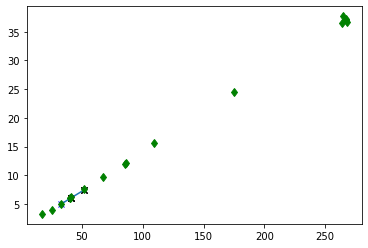

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     95231       1    52  5105  310104  310104   92874 -2.126332  8.278471   
      93689       1    52  5105  310104  310104   91313  8.310192  1.008146   
      94777       1    52  5105  310104  310104   92417  5.065886 -6.785590   
      95482       1    52  5105  310104  310104   93125 -8.382275 -1.721369   
      94035       1    52  5105  310104  310104   91660 -2.716914  8.000412   
      95125       1    52  5105  310104  310104   92767  4.858774  7.118510   
      95439       1    52  5105  310104  310104   93082 -8.499649  1.596838   
      94637       1    52  5105  310104  310104   92275 -0.796271 -8.441720   
      94999       1    52  5105  310104  310104   92641  8.504894  1.020088   
      93723       1    52  5105  310104  310104   91347  8.299717  1.745700   

                        z  parti

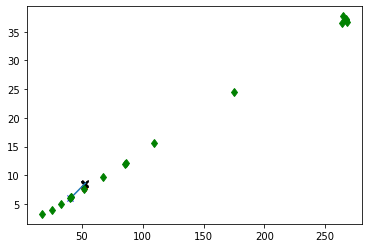

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     99620       1    52  5105  310104  310104   97306  8.393790  4.545346   
      99767       1    52  5105  310104  310104   97454 -0.656744  9.522129   
      99668       1    52  5105  310104  310104   97354  2.250581  9.272390   
      100369      1    52  5105  310104  310104   98063  6.706809 -6.858983   
      100278      1    52  5105  310104  310104   97971  0.582856 -9.521758   
      100372      1    52  5105  310104  310104   98066  6.739214 -6.825495   
      100370      1    52  5105  310104  310104   98064  6.713615 -6.850112   
      100371      1    52  5105  310104  310104   98065  6.718251 -6.844072   
      100142      1    52  5105  310104  310104   97832 -5.965777 -7.505763   
      99580       1    52  5105  310104  310104   97266  8.459854  4.574402   

                        z  parti

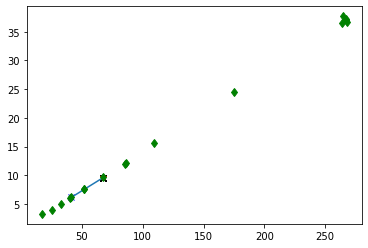

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     105647      1    52  5105  310104  310104  103396 -10.283632  -6.691220   
      104257      1    52  5105  310104  310104  101986   6.159201  10.739302   
      2763        1    52  5105  310104  310104  103638   8.692928  -8.574897   
      105553      1    52  5105  310104  310104  103301 -12.261684  -0.293307   
      105160      1    52  5105  310104  310104  102906  12.197695   0.516822   
      2764        1    52  5105  310104  310104  103611   8.714875  -8.642809   
      105704      1    52  5105  310104  310104  103459  -6.401537 -10.472923   
      104815      1    52  5105  310104  310104  102557  -5.560123 -11.006183   
      104401      1    52  5105  310104  310104  102130  -6.237864  10.685815   
      105516      1    52  5105  310104  310104  103263 -11.778748   3.266076   

        

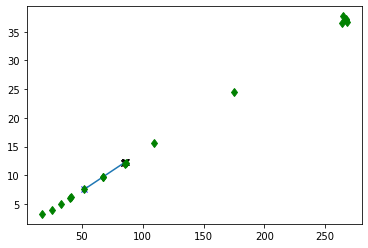

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     104463      1    52  5105  310104  310104  102192  -9.917610   6.786016   
      110045      1    52  5105  310104  310104  107846 -10.291071  10.604431   
      109972      1    52  5105  310104  310104  107773  -6.375860  13.331141   
      110338      1    52  5105  310104  310104  108145  -2.843629 -14.538107   
      110282      1    52  5105  310104  310104  108087 -10.355417 -10.547236   
      104435      1    52  5105  310104  310104  102164  -8.667750   8.339897   
      110178      1    52  5105  310104  310104  107979 -14.102892  -4.605933   
      104206      1    52  5105  310104  310104  101935   9.575038   7.150236   
      110097      1    52  5105  310104  310104  107898 -13.783424   5.365921   
      109993      1    52  5105  310104  310104  107794 -10.325447  10.662492   

        

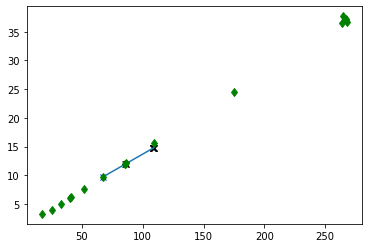

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     187405      1    52  5105  310104  310104  185881  -6.081794  25.709879   
      187670      1    52  5105  310104  310104  186146 -26.319193   2.234737   
      2862        1    52  5105  310104  310104  186678  20.897167 -16.152472   
      188048      1    52  5105  310104  310104  186526   8.268072 -25.066549   
      187781      1    52  5105  310104  310104  186257 -21.683296 -15.150300   
      187404      1    52  5105  310104  310104  185880  -6.476870  25.647305   
      188196      1    52  5105  310104  310104  186677  17.762350 -19.494755   
      187344      1    52  5105  310104  310104  185820   2.127553  26.633226   
      187785      1    52  5105  310104  310104  186261 -24.636505  -9.354301   
      188338      1    52  5105  310104  310104  186822  26.141048  -4.297262   

        

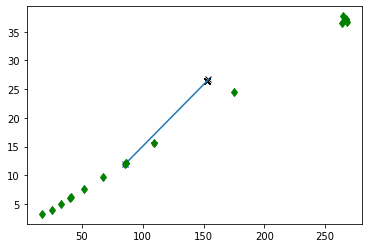

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     187361      1    52  5105  310104  310104  185837   2.142665  23.660259   
      187872      1    52  5105  310104  310104  186349 -18.366503 -15.156229   
      187359      1    52  5105  310104  310104  185835   3.587886  23.579887   
      187641      1    52  5105  310104  310104  186117 -22.323626   8.400296   
      187360      1    52  5105  310104  310104  185836   3.350841  23.617432   
      187998      1    52  5105  310104  310104  186476  -4.891634 -23.373394   
      187577      1    52  5105  310104  310104  186053 -15.704245  17.818487   
      188141      1    52  5105  310104  310104  186620  12.387316 -20.456783   
      187300      1    52  5105  310104  310104  185776   8.796784  22.121605   
      187576      1    52  5105  310104  310104  186052 -18.366503  15.156229   

        

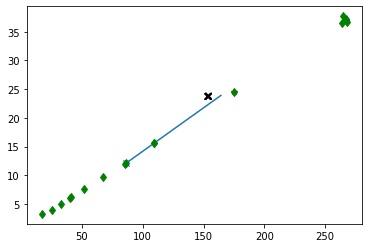

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     213613      1    52  5105  310104  310104  212369 -35.725506   8.312247   
      213428      1    52  5105  310104  310104  212181 -15.979883  33.239044   
      214028      1    52  5105  310104  310104  212790  15.894934 -33.268772   
      214027      1    52  5105  310104  310104  212789  15.852459 -33.283634   
      213751      1    52  5105  310104  310104  212508 -33.143311 -16.142551   
      213110      1    52  5105  310104  310104  211861  33.569439  14.813578   
      213186      1    52  5105  310104  310104  211938  33.271000  15.939338   
      213242      1    52  5105  310104  310104  211995  22.062103  29.510441   
      213328      1    52  5105  310104  310104  212081   1.801524  36.754345   
      213185      1    52  5105  310104  310104  211937  33.324203  15.854666   

        

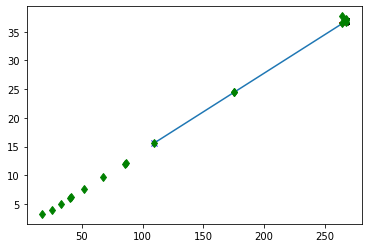

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     213327      1    52  5105  310104  310104  212080   5.143436  36.673061   
      213623      1    52  5105  310104  310104  212379 -36.822536   0.541214   
      213966      1    52  5105  310104  310104  212727   7.805261 -36.004074   
      213492      1    52  5105  310104  310104  212245 -25.797613  26.554239   
      213129      1    52  5105  310104  310104  211880  33.356285  15.644824   
      213131      1    52  5105  310104  310104  211882  33.437202  15.413572   
      213226      1    52  5105  310104  310104  211979  28.387930  23.445259   
      213967      1    52  5105  310104  310104  212728   7.556833 -36.032063   
      213407      1    52  5105  310104  310104  212160 -10.796389  35.441383   
      213705      1    52  5105  310104  310104  212461 -33.457020 -15.356939   

        

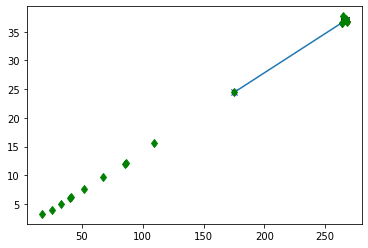

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     219907      1    52  5105  310104  310104  218695  71.402489  20.411451   
      219882      1    52  5105  310104  310104  218666  74.165611   3.808965   
      219981      1    52  5105  310104  310104  218769  42.511173  60.893681   
      220508      1    52  5105  310104  310104  219310  68.301346 -29.163239   
      220236      1    52  5105  310104  310104  219028 -71.629219 -19.624460   
      220237      1    52  5105  310104  310104  219029 -70.996368 -21.821117   
      220238      1    52  5105  310104  310104  219030 -70.970207 -21.911924   
      219905      1    52  5105  310104  310104  218693  71.821068  18.958544   
      220128      1    52  5105  310104  310104  218918 -50.732750  54.257805   
      220366      1    52  5105  310104  310104  219160   5.857737 -74.050552   

        

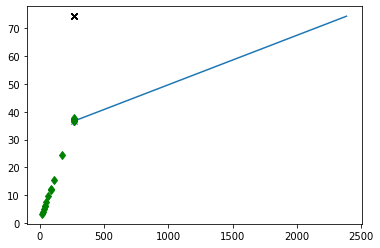

  6%|███████▋                                                                                                              | 13/200 [00:06<02:01,  1.54it/s]

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     261890      1    52  5105  310104  310104  261307  38.830936   6.151396   
      261571      1    52  5105  310104  310104  260978 -35.330486  -3.809777   
      237389      1    52  5105  310104  310104  236465  19.556358 -15.059429   
      261760      1    52  5105  310104  310104  261169  16.692677 -31.367603   
      237087      1    52  5105  310104  310104  236150 -22.035053 -11.020297   
      237089      1    52  5105  310104  310104  236152 -20.475054 -13.722296   
      237134      1    52  5105  310104  310104  236197 -16.534527 -17.517218   
      262134      1    52  5105  310104  310104  261551 -25.168131  29.639637   
      236716      1    52  5105  310104  310104  235775  11.133045  21.403152   
      237030      1    52  5105  310104  310104  236093 -23.012554  -7.239745   

        

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


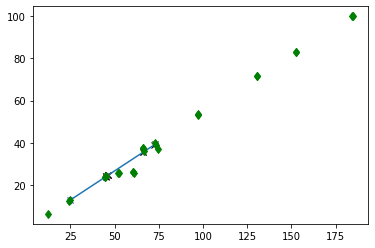

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     236676      1    52  5105  310104  310104  235735  18.827400  16.815752   
      237003      1    52  5105  310104  310104  236066 -25.233782   0.767122   
      236840      1    52  5105  310104  310104  235899 -12.046743  21.070593   
      236647      1    52  5105  310104  310104  235706  14.748583  20.060127   
      237004      1    52  5105  310104  310104  236067 -25.254620   0.648945   
      237320      1    52  5105  310104  310104  236386  18.542124 -15.666796   
      237103      1    52  5105  310104  310104  236166 -23.368296  -9.492191   
      237413      1    52  5105  310104  310104  236490  23.527126  -9.217087   
      1122        1    52  5105  310104  310104  235970 -18.959669  16.704765   
      237288      1    52  5105  310104  310104  236353  11.774001 -22.301641   

        

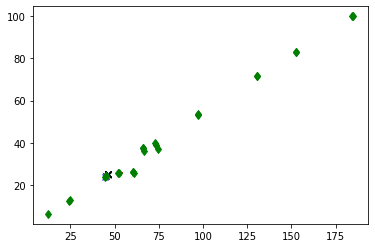

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     237550      1    52  5105  310104  310104  236627  19.130070  17.378702   
      181500      1    52  5105  310104  310104  179841 -38.945530  12.494024   
      182437      1    52  5105  310104  310104  180785 -29.616674 -27.022436   
      237827      1    52  5105  310104  310104  236910 -24.628456   7.803915   
      237946      1    52  5105  310104  310104  237031 -19.273933 -16.877048   
      264715      1    52  5105  310104  310104  264172  35.109261  -6.283854   
      237508      1    52  5105  310104  310104  236585  23.873863   9.284486   
      238379      1    52  5105  310104  310104  237486  20.626820  17.971397   
      237828      1    52  5105  310104  310104  236911 -24.640612   7.734979   
      182502      1    52  5105  310104  310104  180850 -14.372818 -37.631752   

        

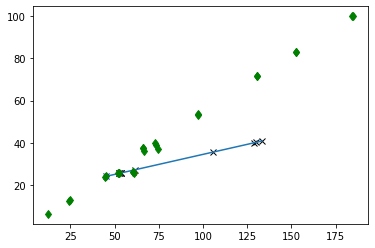

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     242709      1    52  5105  310104  310104  241869   4.417048  26.138641   
      178821      1    52  5105  310104  310104  177152   7.146753 -25.689734   
      238732      1    52  5105  310104  310104  237841 -24.440638   8.091265   
      241668      1    52  5105  310104  310104  240819 -11.881540  23.421789   
      240631      1    52  5105  310104  310104  239767 -18.945230  17.909739   
      242063      1    52  5105  310104  310104  241222 -19.169174 -17.951048   
      242468      1    52  5105  310104  310104  241627  25.123707  -7.664861   
      239338      1    52  5105  310104  310104  238462  16.726412  19.771549   
      241927      1    52  5105  310104  310104  241084 -25.120487  -7.683122   
      241501      1    52  5105  310104  310104  240648   5.138866  25.768152   

        

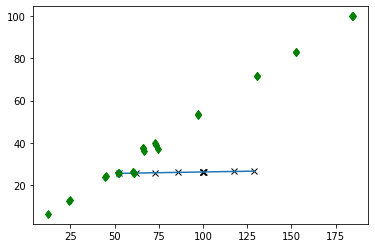

  8%|██████████                                                                                                            | 17/200 [00:07<01:11,  2.55it/s]

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     39490       1    52  5105  310104  310104   36665  -2.719602   8.418451   
      2911        1    52  5105  310104  310104   37737   6.286325   6.634020   
      40499       1    52  5105  310104  310104   37685   8.836076   1.913312   
      222373      1    52  5105  310104  310104  221210 -19.139315  16.826460   
      41271       1    52  5105  310104  310104   38468   6.145280  -6.762302   
      40497       1    52  5105  310104  310104   37683   8.843090   1.870216   
      39453       1    52  5105  310104  310104   36628  -0.818753   8.912324   
      222724      1    52  5105  310104  310104  221565 -12.247515 -22.351387   
      41305       1    52  5105  310104  310104   38502   6.090567  -6.691788   
      34184       1    52  5105  310104  310104   31296  -5.614525  -2.921068   

        

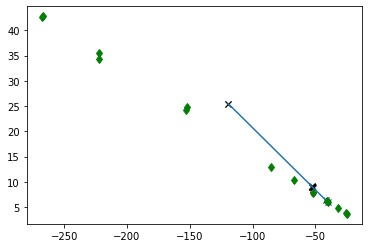

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     45296       1    52  5105  310104  310104   42524  -9.045990   4.863029   
      45187       1    52  5105  310104  310104   42414  -0.648239  10.306016   
      39912       1    52  5105  310104  310104   37091  -7.273089  -3.180285   
      39143       1    52  5105  310104  310104   36315   7.816376   1.368981   
      45577       1    52  5105  310104  310104   42807  -5.412460  -8.784575   
      45042       1    52  5105  310104  310104   42269   6.804078   7.670144   
      45405       1    52  5105  310104  310104   42634 -10.248448  -1.165149   
      45728       1    52  5105  310104  310104   42959   7.037290  -7.592148   
      39963       1    52  5105  310104  310104   37144  -4.402197  -6.636950   
      45392       1    52  5105  310104  310104   42621 -10.115311  -2.210474   

        

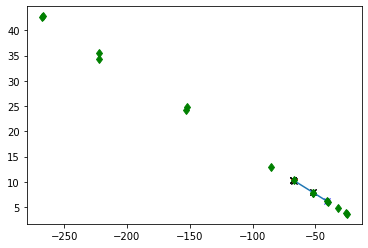

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     45821       1    52  5105  310104  310104   43055   9.651092  -4.170780   
      51203       1    52  5105  310104  310104   48487  13.419439   0.141597   
      45760       1    52  5105  310104  310104   42991   5.083999  -9.204535   
      45824       1    52  5105  310104  310104   43058   9.506773  -4.506085   
      45398       1    52  5105  310104  310104   42627 -10.345997  -1.915562   
      44928       1    52  5105  310104  310104   42153  10.340830   1.801411   
      50880       1    52  5105  310104  310104   48158 -12.407283  -5.237149   
      45184       1    52  5105  310104  310104   42411  -0.762756  10.467473   
      50529       1    52  5105  310104  310104   47805   6.697211  11.604159   
      50636       1    52  5105  310104  310104   47912  -3.527153  12.923607   

        

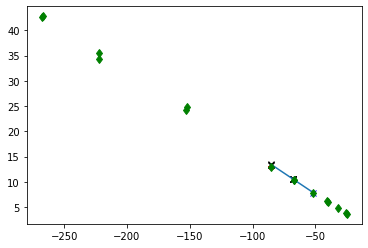

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     51018       1    52  5105  310104  310104   48297   1.833999 -12.933121   
      50872       1    52  5105  310104  310104   48150 -11.813070  -5.605513   
      50597       1    52  5105  310104  310104   47873  -2.595326  12.782218   
      50956       1    52  5105  310104  310104   48234  -2.934599 -12.705799   
      50615       1    52  5105  310104  310104   47891  -0.411554  13.028741   
      50863       1    52  5105  310104  310104   48141 -11.251490  -6.698632   
      50735       1    52  5105  310104  310104   48012 -12.868539   2.447164   
      50855       1    52  5105  310104  310104   48133 -10.634109  -7.513862   
      50498       1    52  5105  310104  310104   47773   8.098954  10.313902   
      50854       1    52  5105  310104  310104   48132 -10.715882  -7.573256   

        

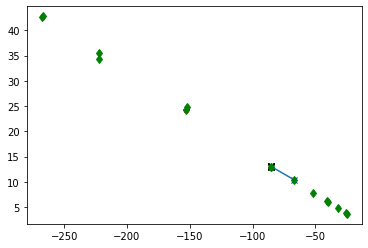

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     143858      1    52  5105  310104  310104  141936 -19.436628 -14.712618   
      143737      1    52  5105  310104  310104  141815 -23.654770   5.928416   
      144338      1    52  5105  310104  310104  142423  24.247656  -2.185077   
      144119      1    52  5105  310104  310104  142197   5.306161 -23.753326   
      144120      1    52  5105  310104  310104  142198   0.122540 -24.425802   
      143857      1    52  5105  310104  310104  141935 -19.309511 -14.962099   
      143602      1    52  5105  310104  310104  141680 -14.975988  19.169140   
      143854      1    52  5105  310104  310104  141932 -20.447134 -13.375658   
      144339      1    52  5105  310104  310104  142424  24.437532  -0.048475   
      144232      1    52  5105  310104  310104  142312  17.796213 -16.763845   

        

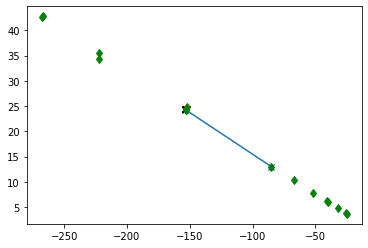

  9%|██████████▌                                                                                                           | 18/200 [00:08<01:22,  2.20it/s]

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     40322       1    52  5105  310104  310104   37505  5.134346 -4.868556   
      33386       1    52  5105  310104  310104   30492  5.502388  1.171435   
      33840       1    52  5105  310104  310104   30950 -4.424142  3.563240   
      34349       1    52  5105  310104  310104   31464 -2.745920 -4.973415   
      33411       1    52  5105  310104  310104   30517  5.382551  1.608064   
      39554       1    52  5105  310104  310104   36731 -3.870808  5.849566   
      34781       1    52  5105  310104  310104   31901  5.477301 -1.521825   
      37744       1    52  5105  310104  310104   34908  6.938866  1.573601   
      38624       1    52  5105  310104  310104   35792 -4.496034 -5.544320   
      39637       1    52  5105  310104  310104   36815 -5.053461  4.967115   

                        z  parti

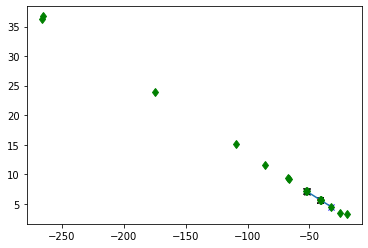

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     40560       1    52  5105  310104  310104   37748   6.605387   5.215021   
      40633       1    52  5105  310104  310104   37824   3.140638   7.807554   
      222995      1    52  5105  310104  310104  221838  19.855942 -13.454854   
      40401       1    52  5105  310104  310104   37586   7.601687  -3.135413   
      40936       1    52  5105  310104  310104   38132  -8.296832  -1.328066   
      33861       1    52  5105  310104  310104   30971  -4.190870   3.923938   
      41208       1    52  5105  310104  310104   38404   0.378361  -8.427813   
      40355       1    52  5105  310104  310104   37540   7.497184  -3.111459   
      39270       1    52  5105  310104  310104   36444   6.401165   5.060871   
      40232       1    52  5105  310104  310104   37414   4.323621  -7.030901   

        

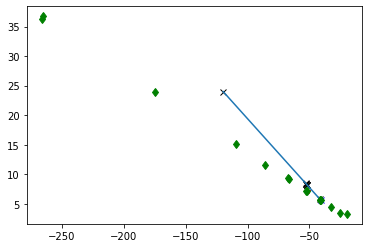

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     44914       1    52  5105  310104  310104   42139  8.784378  2.655560   
      43755       1    52  5105  310104  310104   40974  6.874441  5.834137   
      44217       1    52  5105  310104  310104   41439 -8.427359  3.359753   
      45727       1    52  5105  310104  310104   42957  6.569435 -6.411598   
      43753       1    52  5105  310104  310104   40972  6.897019  5.813858   
      37841       1    52  5105  310104  310104   35005  5.204587  4.942954   
      38943       1    52  5105  310104  310104   36112  5.256288 -4.982284   
      45050       1    52  5105  310104  310104   42277  5.272592  7.431939   
      38297       1    52  5105  310104  310104   35464 -6.429094  3.174776   
      45130       1    52  5105  310104  310104   42357  1.929664  8.930433   

                        z  parti

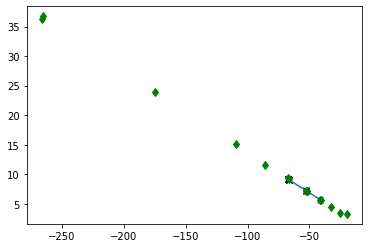

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     45192       1    52  5105  310104  310104   42419  -0.317801  10.697717   
      45827       1    52  5105  310104  310104   43061   9.504402  -4.944830   
      45379       1    52  5105  310104  310104   42608 -10.621372  -0.099415   
      45152       1    52  5105  310104  310104   42379  -0.301666  10.617705   
      38958       1    52  5105  310104  310104   36127   4.994707  -5.328815   
      45694       1    52  5105  310104  310104   42924   4.276110  -9.699559   
      1653        1    52  5105  310104  310104   42534 -10.167960   3.396260   
      39061       1    52  5105  310104  310104   36232   7.312340  -0.559541   
      45519       1    52  5105  310104  310104   42749  -6.685020  -8.215793   
      44994       1    52  5105  310104  310104   42220   9.434371   4.811687   

        

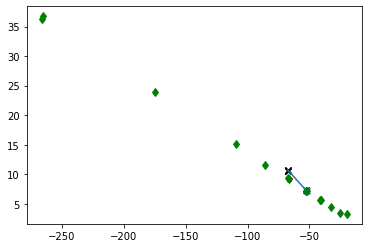

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     49463       1    52  5105  310104  310104   46730  11.661127   0.856865   
      49608       1    52  5105  310104  310104   46875   5.122586  10.508431   
      49695       1    52  5105  310104  310104   46962  -3.906218  10.968922   
      45068       1    52  5105  310104  310104   42295   1.951515   8.993634   
      45332       1    52  5105  310104  310104   42561  -8.064681   4.429657   
      50219       1    52  5105  310104  310104   47490   4.678391 -10.670751   
      45100       1    52  5105  310104  310104   42327   4.145973   8.242137   
      45782       1    52  5105  310104  310104   43014   7.398493  -5.423393   
      44910       1    52  5105  310104  310104   42135   8.781387   2.831676   
      44974       1    52  5105  310104  310104   42200   8.706629   2.801375   

        

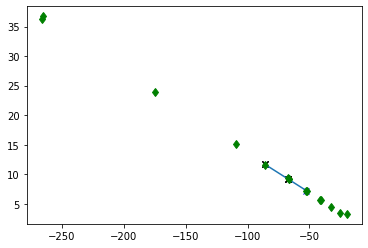

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     50473       1    52  5105  310104  310104   47748   9.786586   8.654209   
      50967       1    52  5105  310104  310104   48245  -3.674594 -12.617331   
      50417       1    52  5105  310104  310104   47692  12.622032   3.314209   
      50739       1    52  5105  310104  310104   48016 -12.753036   3.141012   
      50812       1    52  5105  310104  310104   48089 -13.160686   0.224860   
      50887       1    52  5105  310104  310104   48165 -10.940090  -7.162348   
      50432       1    52  5105  310104  310104   47707  10.746509   7.600910   
      50860       1    52  5105  310104  310104   48138 -11.008103  -7.217690   
      50462       1    52  5105  310104  310104   47737  10.690811   7.536675   
      50468       1    52  5105  310104  310104   47743  10.121187   8.286434   

        

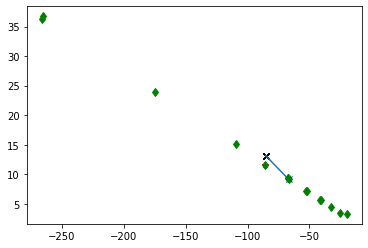

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     55161       1    52  5105  310104  310104   52470  10.668234   9.710872   
      55218       1    52  5105  310104  310104   52527   6.193043  13.031541   
      55255       1    52  5105  310104  310104   52564   5.567800  13.350784   
      55887       1    52  5105  310104  310104   53198  14.438393   0.068872   
      55225       1    52  5105  310104  310104   52534   5.821821  13.214639   
      55372       1    52  5105  310104  310104   52681 -11.421510   8.864018   
      55253       1    52  5105  310104  310104   52562   5.527812  13.346642   
      55766       1    52  5105  310104  310104   53076   5.481511 -13.434566   
      55656       1    52  5105  310104  310104   52966  -2.950106 -14.156222   
      55777       1    52  5105  310104  310104   53087   9.177641 -11.177077   

        

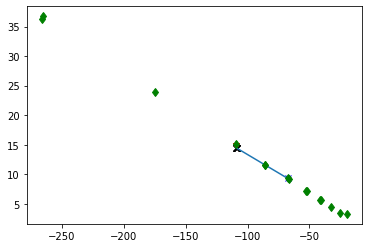

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     64749       1    52  5105  310104  310104   62100 -17.034649  18.099117   
      64991       1    52  5105  310104  310104   62344  -3.449049 -24.727144   
      64529       1    52  5105  310104  310104   61879  24.518234   3.932584   
      65175       1    52  5105  310104  310104   62528  24.822945  -0.380102   
      64899       1    52  5105  310104  310104   62250 -20.986242 -13.472316   
      64910       1    52  5105  310104  310104   62261 -19.581913 -15.237556   
      64762       1    52  5105  310104  310104   62113 -19.608707  15.532851   
      64755       1    52  5105  310104  310104   62106 -17.936586  17.311085   
      64875       1    52  5105  310104  310104   62226 -23.062437  -9.460230   
      65066       1    52  5105  310104  310104   62419  11.779217 -21.947124   

        

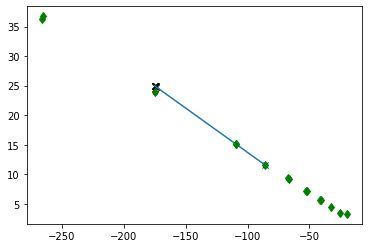

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     169001      1    52  5105  310104  310104  167260  29.370853  20.905577   
      169417      1    52  5105  310104  310104  167678 -36.178513   1.671231   
      169000      1    52  5105  310104  310104  167259  30.126339  19.703230   
      168922      1    52  5105  310104  310104  167181  36.054569   1.461041   
      169818      1    52  5105  310104  310104  168083  14.525398 -33.048592   
      168951      1    52  5105  310104  310104  167210  32.487129  16.129965   
      1643        1    52  5105  310104  310104  167679 -36.089054  -0.155271   
      169817      1    52  5105  310104  310104  168082  11.345769 -34.316616   
      169003      1    52  5105  310104  310104  167262  32.391762  15.546360   
      169880      1    52  5105  310104  310104  168147  15.696349 -32.470772   

        

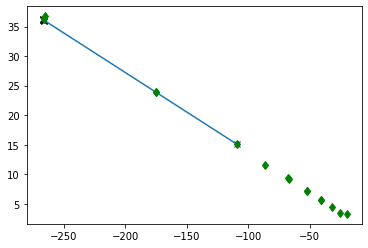

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     169878      1    52  5105  310104  310104  168145  21.781361 -29.167074   
      169128      1    52  5105  310104  310104  167387   8.930676  35.317116   
      169216      1    52  5105  310104  310104  167475  -2.344998  36.397854   
      169527      1    52  5105  310104  310104  167792 -34.536011 -11.162935   
      169606      1    52  5105  310104  310104  167871 -27.111580 -24.410412   
      168951      1    52  5105  310104  310104  167210  32.487129  16.129965   
      169416      1    52  5105  310104  310104  167677 -36.461113   1.783578   
      169968      1    52  5105  310104  310104  168236  29.496105 -21.533445   
      169417      1    52  5105  310104  310104  167678 -36.178513   1.671231   
      169528      1    52  5105  310104  310104  167793 -32.751350 -15.374859   

        

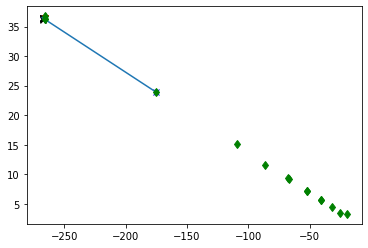

 10%|███████████▏                                                                                                          | 19/200 [00:09<02:04,  1.45it/s]

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     28497       1    52  5105  310104  310104   25538   5.958959  -6.476217   
      227557      1    52  5105  310104  310104  226441  15.147830 -21.002647   
      33063       1    52  5105  310104  310104   30167 -11.253161  -5.973412   
      33199       1    52  5105  310104  310104   30303  -0.013818 -12.763016   
      227511      1    52  5105  310104  310104  226395   8.594510 -25.071238   
      33133       1    52  5105  310104  310104   30237  -5.595379 -11.186827   
      28006       1    52  5105  310104  310104   25031   2.415925   8.454504   
      27950       1    52  5105  310104  310104   24975   7.163157   5.096612   
      32890       1    52  5105  310104  310104   29981  -0.451147  12.470018   
      227198      1    52  5105  310104  310104  226075 -25.484209   7.340475   

        

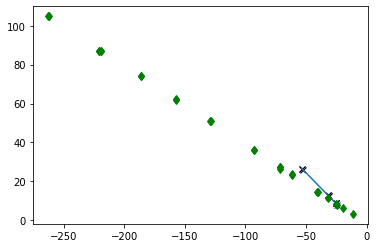

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     37606       1    52  5105  310104  310104   34767  10.348526 -10.497175   
      32198       1    52  5105  310104  310104   29284 -11.229238   2.833016   
      225117      1    52  5105  310104  310104  223970  27.945684   0.394440   
      37039       1    52  5105  310104  310104   34189  12.019173   8.550836   
      226735      1    52  5105  310104  310104  225600  13.327068 -19.407433   
      36980       1    52  5105  310104  310104   34130  14.895124   0.406937   
      226814      1    52  5105  310104  310104  225679  23.570547   0.351628   
      37635       1    52  5105  310104  310104   34797  10.449978 -10.647521   
      37613       1    52  5105  310104  310104   34774  12.376565  -8.331530   
      37626       1    52  5105  310104  310104   34788  11.120645  -9.946323   

        

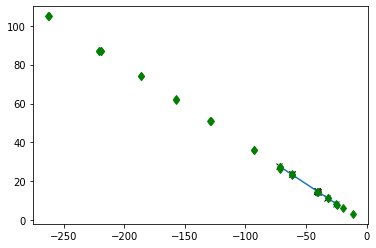

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     37128       1    52  5105  310104  310104   34278   4.397954  14.045972   
      37657       1    52  5105  310104  310104   34820  14.345967  -3.183824   
      225795      1    52  5105  310104  310104  224650   1.219270 -26.676825   
      225534      1    52  5105  310104  310104  224389 -26.426691   5.760735   
      226081      1    52  5105  310104  310104  224940  19.203316  12.477609   
      225293      1    52  5105  310104  310104  224146  10.022104  24.741137   
      1592        1    52  5105  310104  310104   34314  -3.016379  14.365901   
      225292      1    52  5105  310104  310104  224145   9.796577  24.823221   
      36965       1    52  5105  310104  310104   34115  14.497026   2.258080   
      225632      1    52  5105  310104  310104  224487 -22.361950 -15.319072   

        

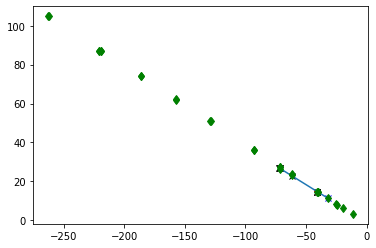

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     226352      1    52  5105  310104  310104  225213 -18.124273  19.754997   
      226351      1    52  5105  310104  310104  225212 -18.101292  19.774281   
      226071      1    52  5105  310104  310104  224930  26.573330   3.533829   
      226174      1    52  5105  310104  310104  225033  16.123777  21.433613   
      226451      1    52  5105  310104  310104  225314 -26.182875   5.748205   
      226268      1    52  5105  310104  310104  225128   1.454268  26.783264   
      226175      1    52  5105  310104  310104  225034  16.096966  21.456110   
      226267      1    52  5105  310104  310104  225127   1.494268  26.783264   
      226754      1    52  5105  310104  310104  225619  18.976562 -17.980469   
      1270        1    52  5105  310104  310104  225502  -8.469055 -25.419670   

        

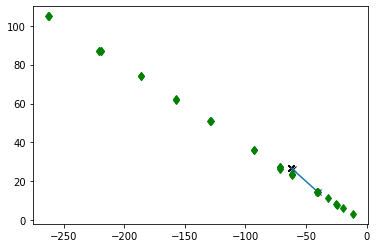

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     139550      1    52  5105  310104  310104  137591 -43.531811 -26.831173   
      139276      1    52  5105  310104  310104  137315  35.316761  36.151157   
      252009      1    52  5105  310104  310104  251267   7.712916  35.111389   
      225170      1    52  5105  310104  310104  224023  25.107046  10.713072   
      252221      1    52  5105  310104  310104  251481 -35.567768  -5.214151   
      139267      1    52  5105  310104  310104  137306  40.127632  31.692841   
      252075      1    52  5105  310104  310104  251335  -7.793334  35.091564   
      251846      1    52  5105  310104  310104  251104  36.184631   4.248542   
      252156      1    52  5105  310104  310104  251416 -33.895557  11.968367   
      251992      1    52  5105  310104  310104  251250   4.490988  35.849728   

        

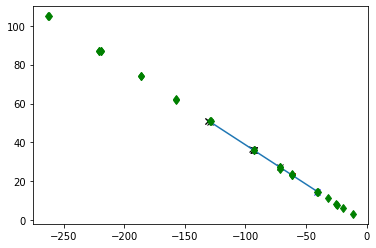

 10%|████████████▍                                                                                                         | 21/200 [00:10<01:31,  1.96it/s]

pid -22456.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     233616      1    52  5105  310104  310104  232571 -25.209906  -6.580812   
      233936      1    52  5105  310104  310104  232920  15.105868 -21.225651   
      233427      1    52  5105  310104  310104  232382  -8.978225  24.614311   
      233373      1    52  5105  310104  310104  232328  10.824320  23.696602   
      233686      1    52  5105  310104  310104  232662 -15.074183 -21.252237   
      233930      1    52  5105  310104  310104  232914  18.315594 -18.532372   
      233446      1    52  5105  310104  310104  232401  -6.958765  25.103548   
      233935      1    52  5105  310104  310104  232919  15.128849 -21.206367   
      233937      1    52  5105  310104  310104  232921  15.052245 -21.270645   
      233617      1    52  5105  310104  310104  232572 -25.227272  -6.482332   

        

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [14]:

hits = hits[hits['particle_id'].isin(allowed_pids)]

success = 0 
tries = 0 
num_comp = []

hitsfound = 0 
rewards = [] 
rewards_track = [] 


selected_hits_z = []
selected_hits_r = [] 

hit1_z = []
hit1_r = []

hit2_z = []
hit2_r = [] 
pids = [] 

under= []
over= [] 

not_in_comp_mod = 0 
not_allowed_pid = []

#for pid in tqdm(np.unique(hits.particle_id)): 
for pid in tqdm(np.unique(allowed_pids)[:200]): 
#for pid in rl_pids[: 
#for pid in tqdm(safe_pids):
    p = hits[hits['particle_id']==pid].reset_index()
    if len(p) < 4: 
        print("nope")
        continue
        #print(p)
    start_hit = p.iloc[0]
    if np.abs(start_hit.z) > 30: 
        continue
    next_start_hit = p[(p['r'] > start_hit.r) & (p['unique_layer_id']!=start_hit.unique_layer_id)].iloc[0]
    start_i = next_start_hit.name + 1 
    
    #next_start_hit = p.iloc[1]

    #if start_hit.unique_layer_id == next_start_hit.unique_layer_id: 
    #    next_start_hit = p.iloc[2]
    #track_reward = 0 

    m = (next_start_hit.r - start_hit.r)/(next_start_hit.z - start_hit.z)
    b = next_start_hit.r - m*next_start_hit.z
    #print(p)
    hitids = [] 
    prev_m = m 
    prev_b = b 
    for i in range(start_i, len(p)-2):
        #print(hit1)
        hit1 = p.iloc[i]
        hit2 = p.iloc[i+1]
        hit3 = p.iloc[i+2]
        
        m = (hit2.r - hit1.r)/(hit2.z - hit1.z)
        b = hit2.r - m*hit2.z
# how much does this matter
        if hit2.unique_layer_id != hit1.unique_layer_id: 
            m = (hit2.r - hit1.r)/(hit2.z - hit1.z)
            b = hit2.r - m*hit2.z
        else: 
            #print("keeping prev vlas")
            pass 
        

        dm = m - prev_m 
        db = b - prev_b
#         m = m - dm 
#         b = b - db
#         prev_m = m 
#         prev_b = b
        #print(dm)
        
        #m = m + dm
        
        #removing inwards ones 
        if (hit1.z < 0) & (m > 0): 
            not_allowed_pid.append(pid)
            break 
        elif (hit1.z > 0) & (m < 0):
            not_allowed_pid.append(pid)
            break
        
        try: 
            comp_mod = mappings[str(int(hit2.discrete_module_id))]
            #print("hit2 mod id", hit2.discrete_module_id)
        except: 
            print("haven't seen this module", hit2.discrete_module_id)
            comp_mod = []
        
        comp_hits = hits[hits['discrete_module_id'].isin(comp_mod)]

            
        
    
        if m > 0: 
            comp_hits = comp_hits[((comp_hits['z'] > hit2.z )) ] #|  (hits['z'] == hit2.z))]
        else: 
            comp_hits = comp_hits[((comp_hits['z'] < hit2.z))] #|  (hits['z'] == hit2.z))] 
        
        #comp_hits = compy[compy['discrete_module_id'].isin(comp_mod) & 
        #            (compy['r'] > hit2.r)]# & 
                    #(np.abs(hits['z']) > np.abs(hit2.z))]
            
        comp_hits = comp_hits[comp_hits['discrete_module_id'].isin(comp_mod)]
        #print("is in comp hits", hit3.hit_id in comp_hits.hit_id)
        num_comp.append(len(comp_hits))
        
        #comp_hits 
        distances = calc_distance(m,b, comp_hits.z, comp_hits.r)
        num_close = 10
        

        if len(comp_hits) > num_close: 
            idx = np.argpartition(distances, range(num_close))
            final = comp_hits.iloc[idx.values][:num_close]
        else: 
            final = comp_hits 
        
 
        #print("hit is ", hit2[['z', 'r']], "final is ", final, "and hit found is", hit3.hit_id in final.hit_id.values)

        hitids.append(final.hit_id.values)
        if hit3.hit_id in final.hit_id.values: 
            hitsfound += 1 
            
        else: 
            #print("hit1", hit1[['z', 'r']], "hit2", hit2[['z', 'r']], "hit3", hit3[['z', 'r']])
            not_allowed_pid.append(pid)
            if hit3.discrete_module_id not in comp_mod: 
                #print("it wasn't in the comp mods")
                not_in_comp_mod +=1 
                #not_allowed_pid.append(pid)
            
            hit3_line_r = eval_line_at_point(m, b, hit3.z)
            if hit3.r - hit3_line_r  < 0: 
                under.append(  hit3.r - hit3_line_r)
            else: 
                over.append(  hit3.r - hit3_line_r)

            print("pid", pid)
            print("final", final)
            print("distances", distances)
            #print("idx", idx)
            plt.plot(final.z, final.r, "kx")
            plt.plot(hit1.z, hit1.r, "bx")
            plt.plot(hit2.z, hit2.r, "gd")
            plt.plot(hit3.z, hit3.r, "r*")
            plt.plot()
            y = np.linspace(hit1.r, np.max(final.r), 1000)
            x = (y -b )/m 
            plt.plot(x, y)
            print("particle id is", p.particle_id.iloc[0])
            print("is in mapping", hit3.discrete_module_id in comp_mod)
            print("hit 2 z", hit2.z, "hit3 z", hit3.z)
            plt.plot(p.z, p.r, "gd")
            print("hit 1 layer", hit1.unique_layer_id, "hit 2 lauer", hit2.unique_layer_id)
            print("dm is ", dm, "db is", db)
            print("distance line and correct hit", calc_distance(m, b, hit3.z, hit3.r))
            print("m", m, " b ", b)
            print("hit3 ", hit3.z, hit3.r)
#             #print("distance line and best hit ", calc_distance(m, b, final.iloc[0].z, final.iloc[0].r))
# #             for vol in hor_vol: 
# #                 v = md[md['volume_id']==vol]
# #                 for i in range(v.shape[0]): 
# #                     row = v.iloc[i]
# #                     plt.plot([row.z_min,row.z_max], [row.r_mean, row.r_mean], "r")

# #             for vol in ver_vol: 
# #                 v = md[md['volume_id']==vol]
# #                 for i in range(v.shape[0]): 
# #                     row = v.iloc[i]
# #                     plt.plot([row.z_mean,row.z_mean], [row.r_min, row.r_max], "r")
        plt.show()
        tries +=1 
        try: 
            selected_hit = final.iloc[0]
            #print("hit3", hit3[['z', 'r']], "selected_hit", selected_hit[['z', 'r']])
        except:
            #print(final)
            pass
        #reward = -np.sqrt((hit3.z - selected_hit.z)**2 + (hit3.r - selected_hit.r)**2)
        #rewards.append(reward)
        #track_reward += reward
#         selected_hits_z.append(selected_hit.z)
#         selected_hits_r.append(selected_hit.r)
#         pids.append(pid)
#         hit1_z.append(hit1.z)
#         hit1_r.append(hit1.r)
#         hit2_z.append(hit2.z)
#         hit2_r.append(hit2.r)
        #print(final)
    #rewards_track.append(track_reward)

In [15]:
hitsfound/tries

0.028169014084507043

In [14]:
len(hits[hits['volume_id']==6]['layer_id'].value_counts())

5

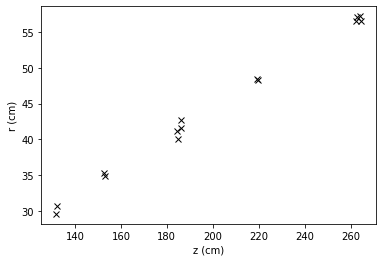

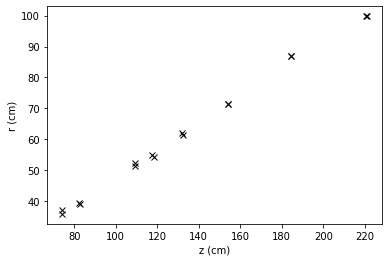

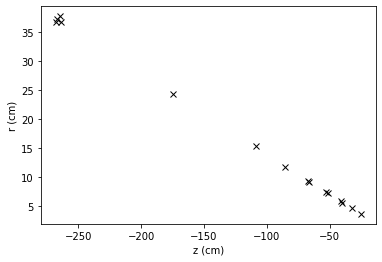

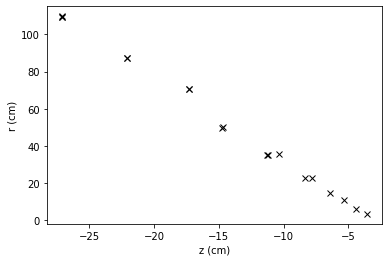

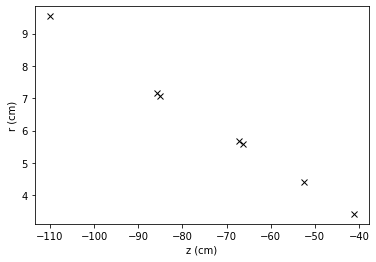

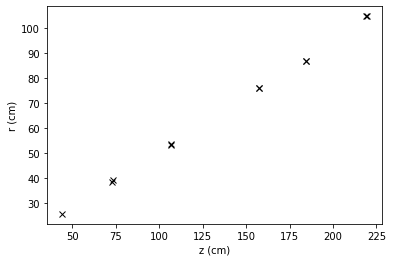

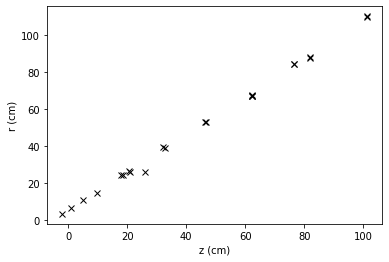

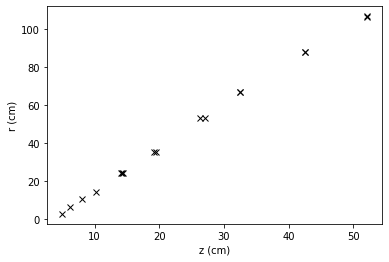

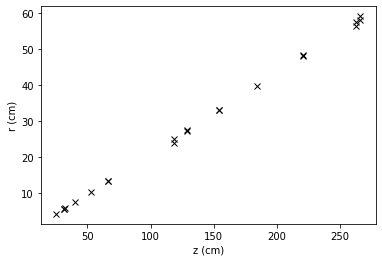

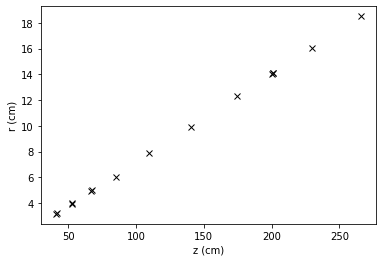

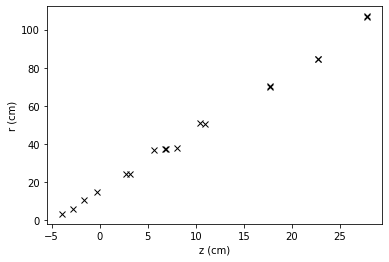

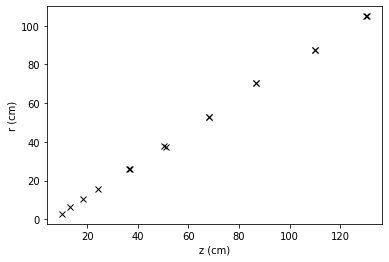

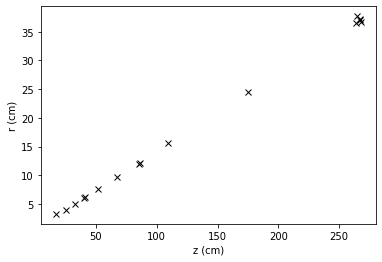

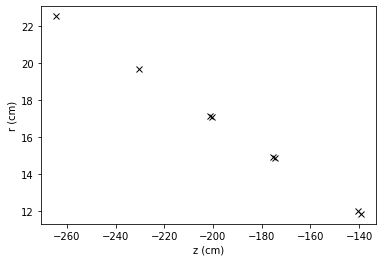

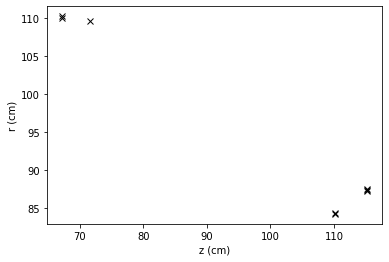

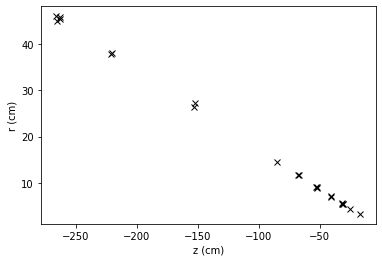

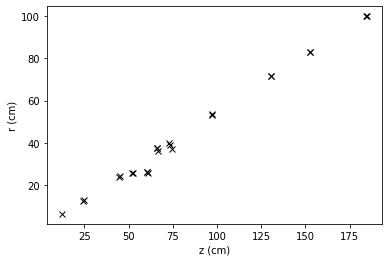

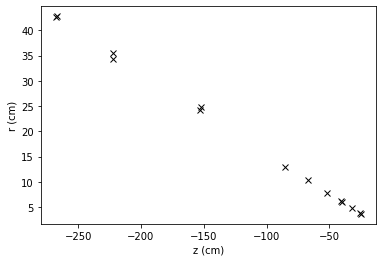

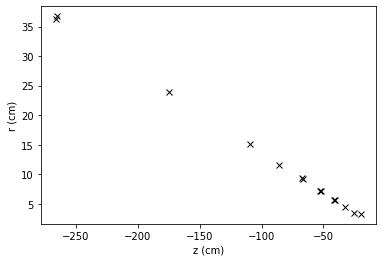

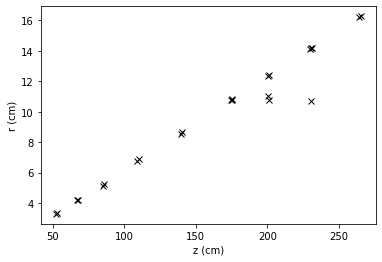

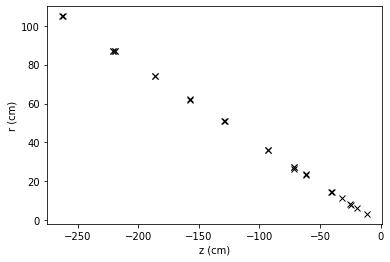

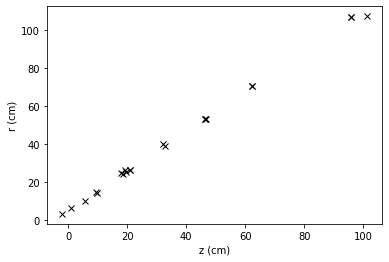

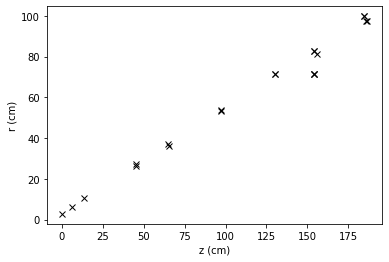

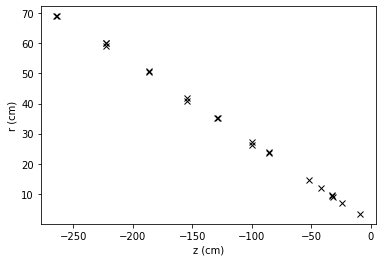

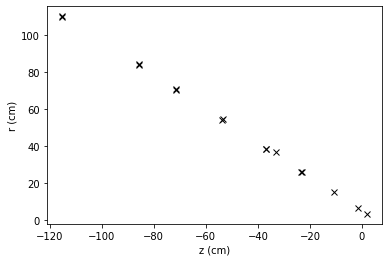

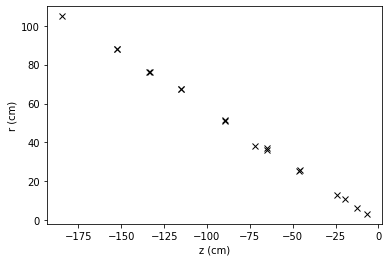

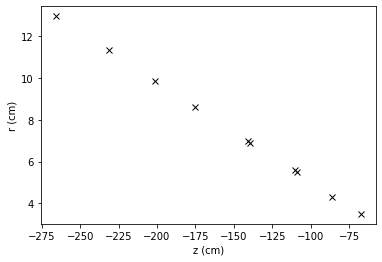

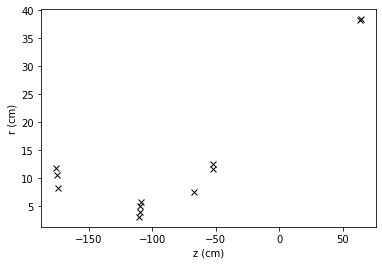

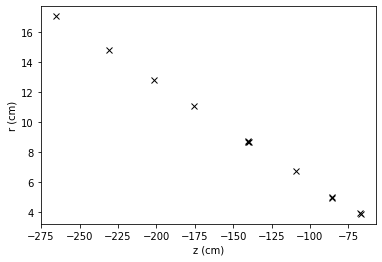

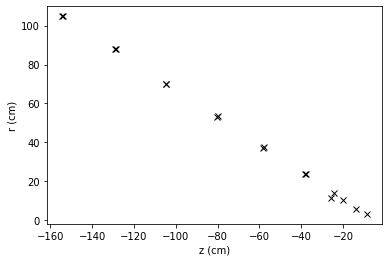

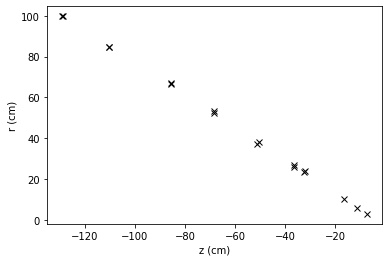

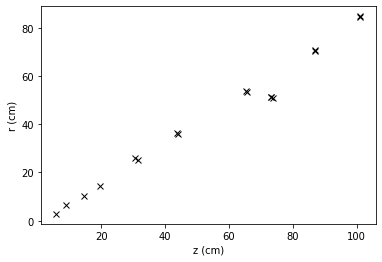

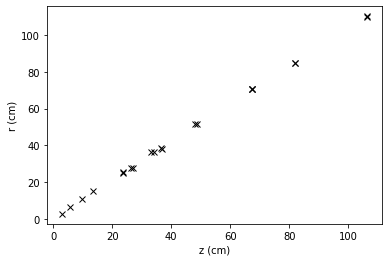

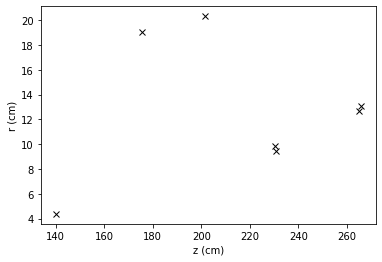

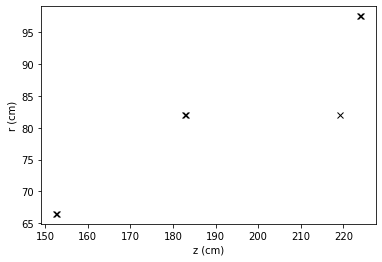

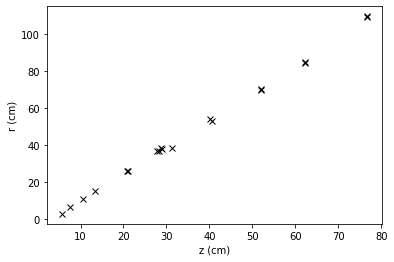

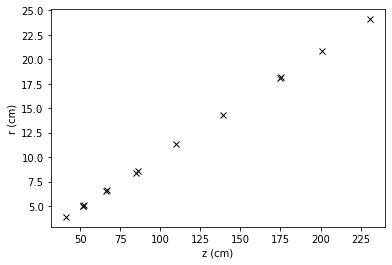

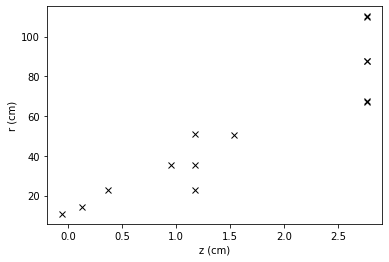

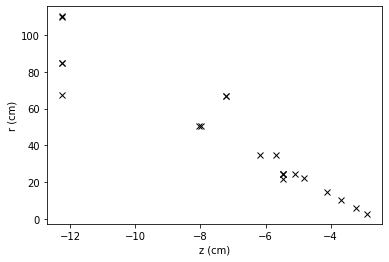

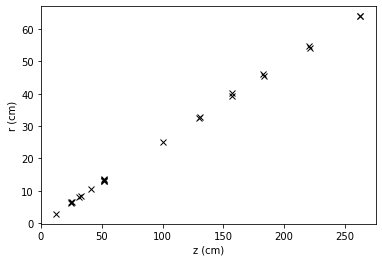

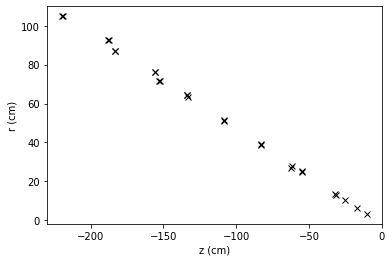

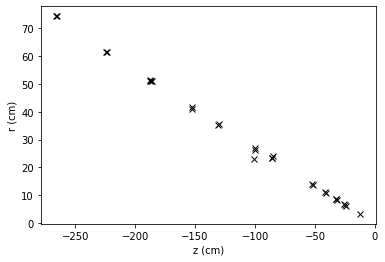

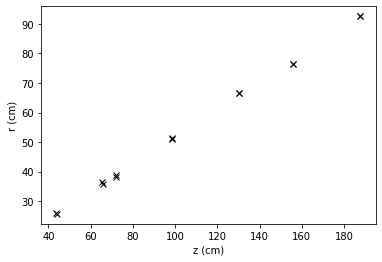

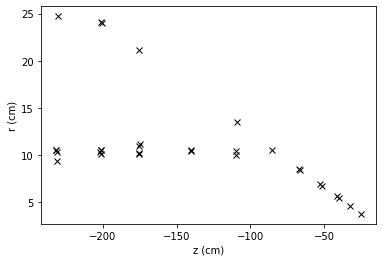

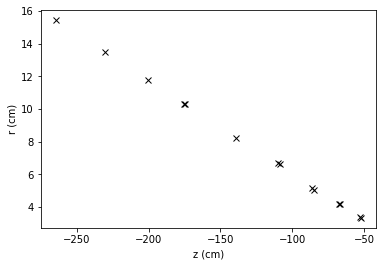

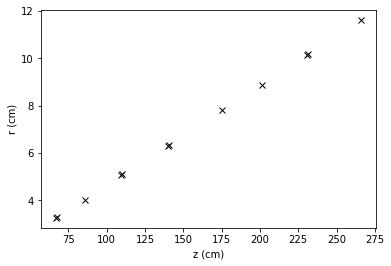

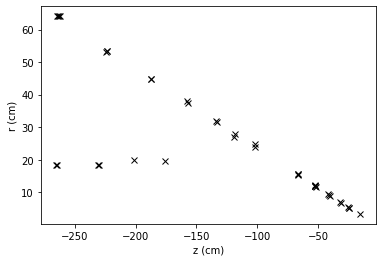

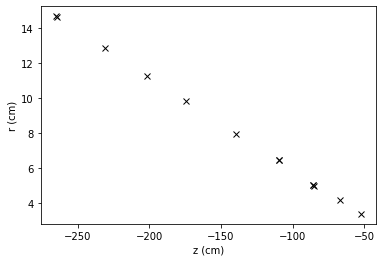

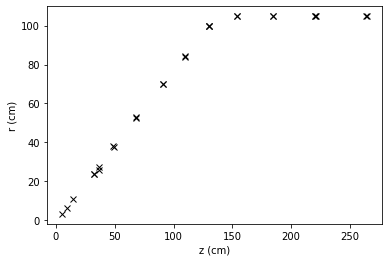

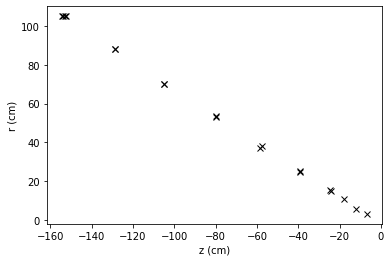

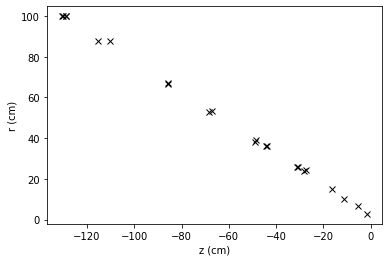

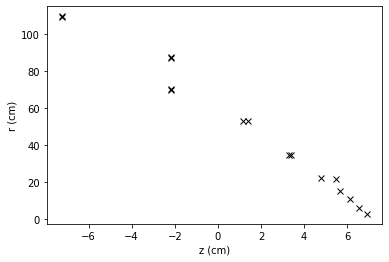

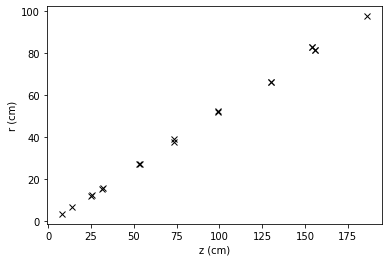

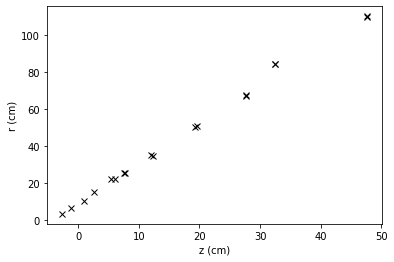

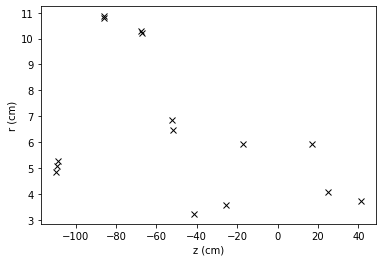

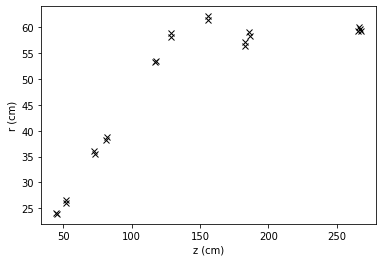

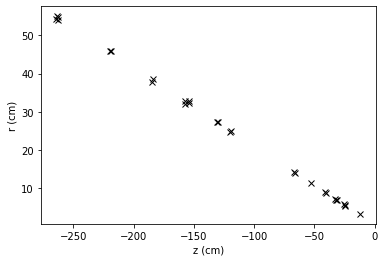

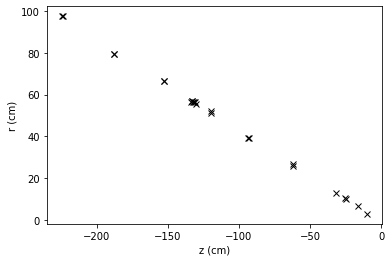

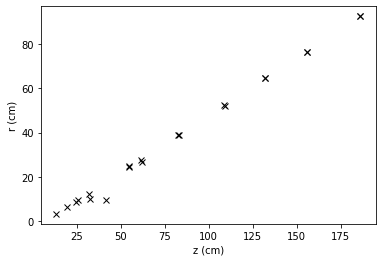

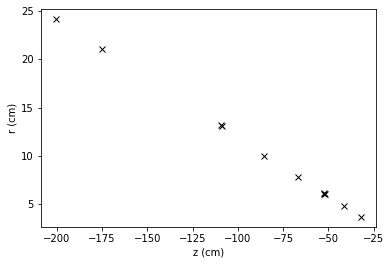

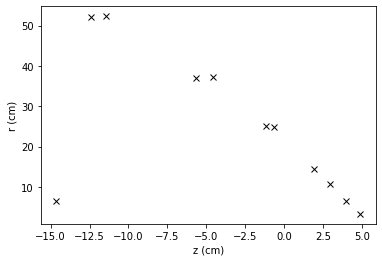

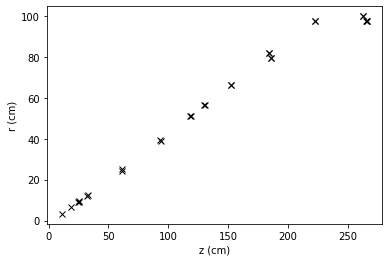

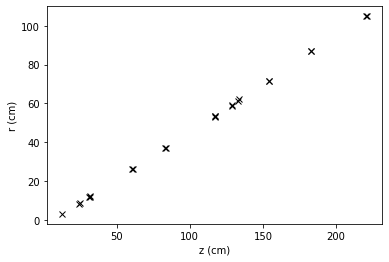

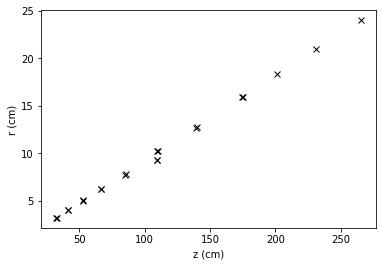

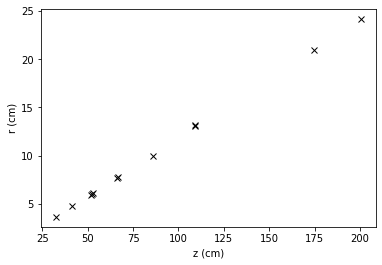

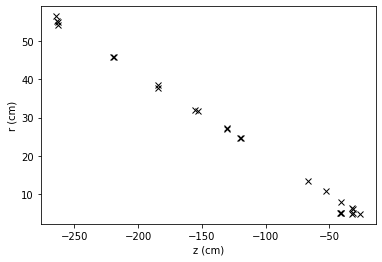

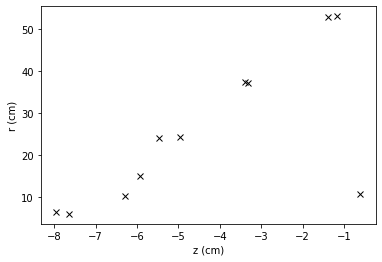

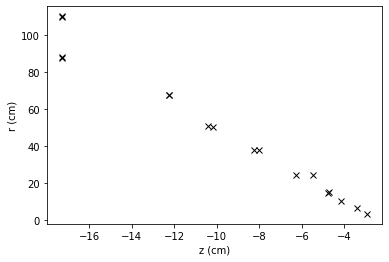

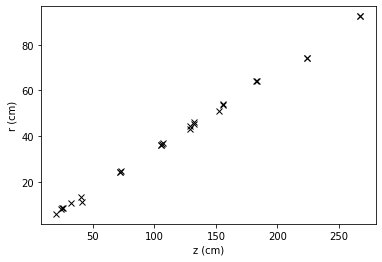

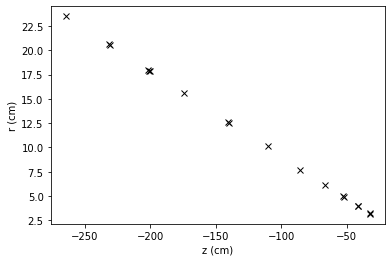

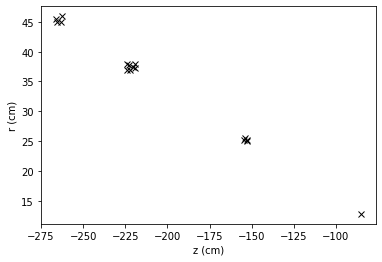

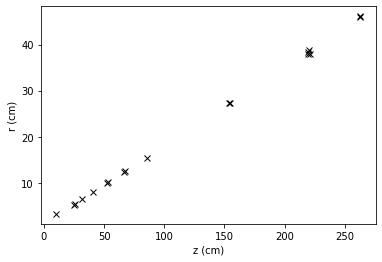

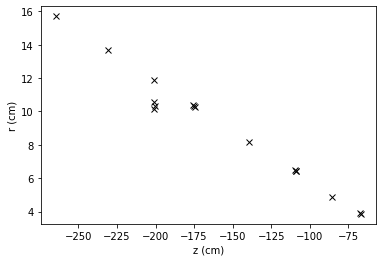

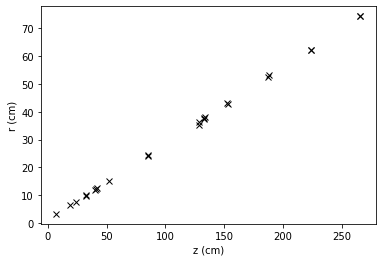

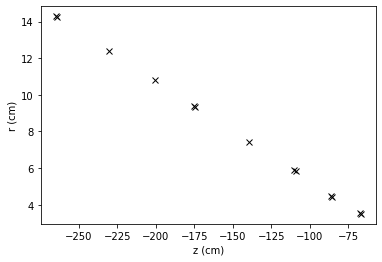

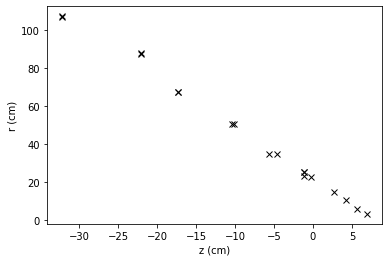

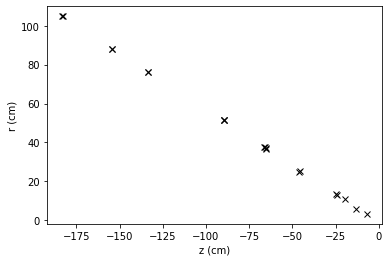

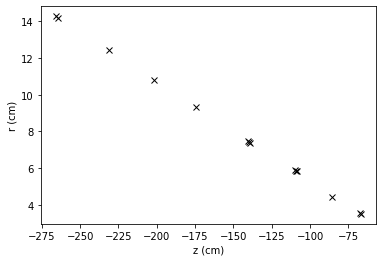

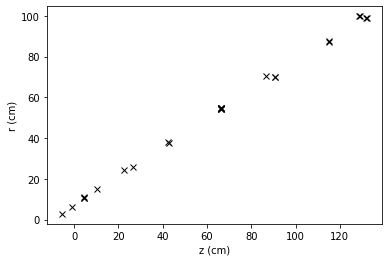

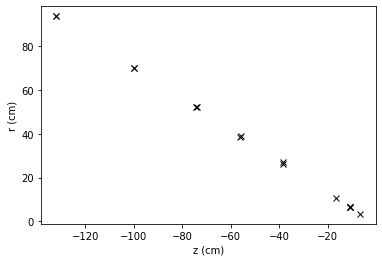

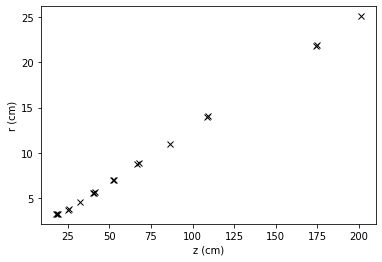

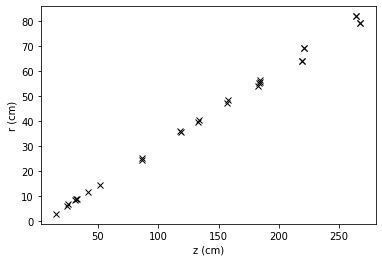

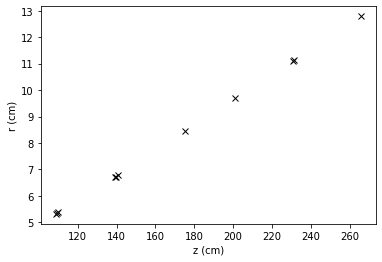

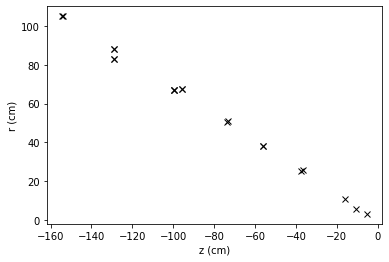

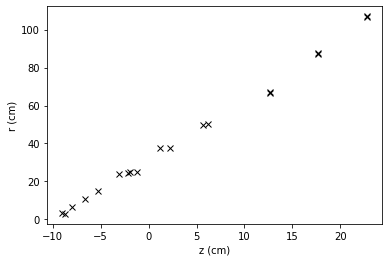

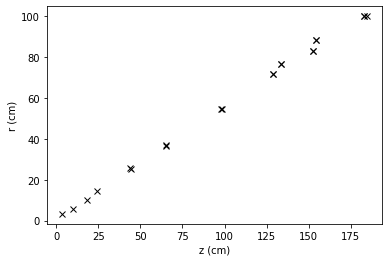

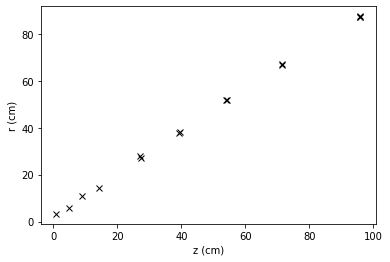

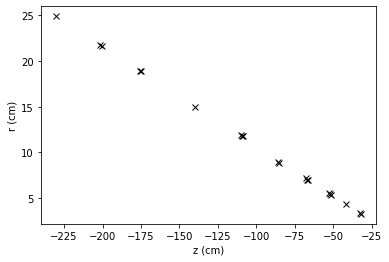

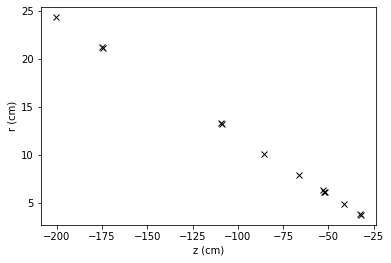

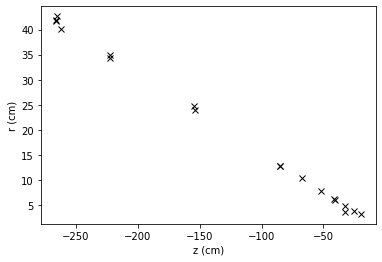

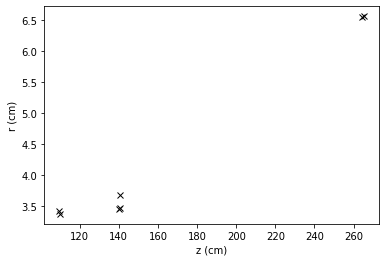

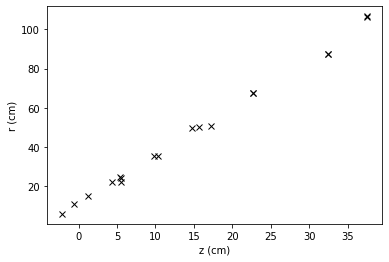

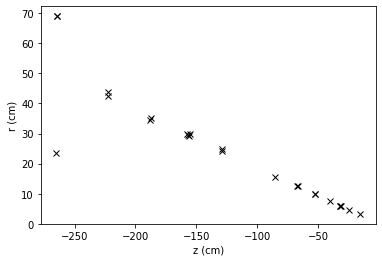

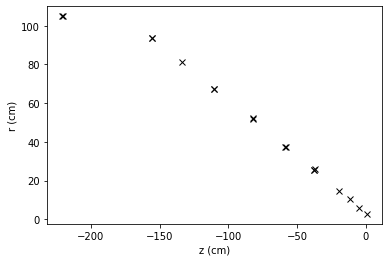

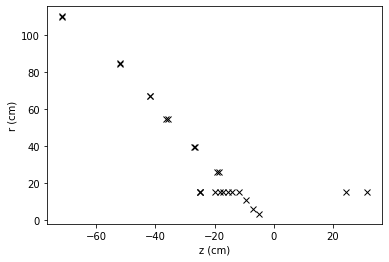

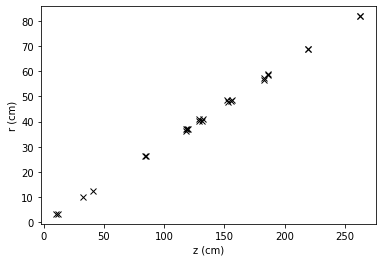

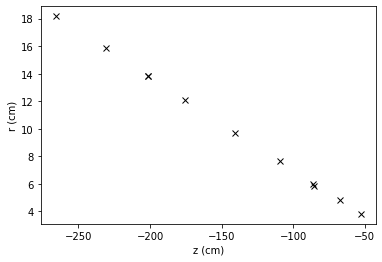

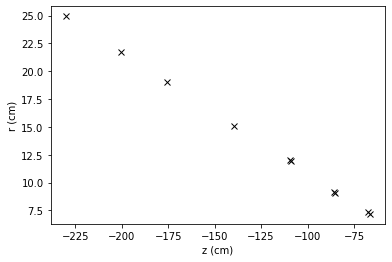

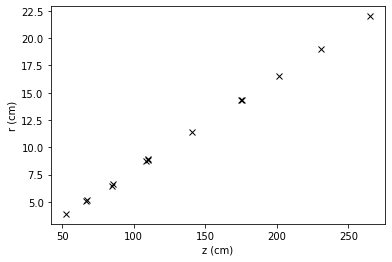

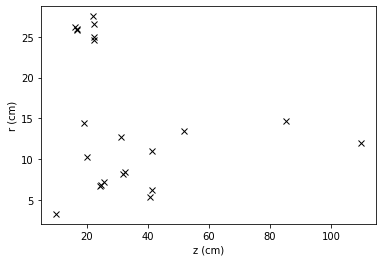

In [18]:
for pid in np.unique(hits.particle_id)[:100]: 
    p = hits[hits['particle_id']==pid]
    plt.plot(p.z, p.r, "kx")
    plt.xlabel("z (cm)")
    plt.ylabel("r (cm)")
    plt.show()

In [32]:
num_comp

[9431,
 12069,
 13825,
 8839,
 13094,
 9548,
 12707,
 10066,
 12375,
 19707,
 18605,
 10684,
 1836,
 21356,
 19903,
 14340,
 29993,
 13586,
 16082,
 15863,
 23433,
 22122,
 11650,
 11615,
 1486,
 1486,
 898,
 282,
 564,
 120,
 2445,
 20628,
 19427,
 13856,
 29179,
 29093,
 13631,
 14066,
 14695,
 12950,
 12017,
 13616,
 14604,
 9461,
 9461,
 14314,
 14314,
 10498,
 10498,
 9206,
 11421,
 11421,
 6749,
 6749,
 3429,
 13234,
 13222,
 11921,
 16565,
 15470,
 25677,
 22420,
 20504,
 23657,
 21789,
 22728,
 20343,
 17209,
 17612,
 15756,
 14034,
 22555,
 22555,
 15119,
 14206,
 14091,
 13967,
 13176,
 12137,
 14481,
 21462,
 20497,
 21860,
 23834,
 5207,
 1962,
 23293,
 21909,
 21285,
 20333,
 19438,
 16187,
 371,
 183,
 183,
 183,
 13409,
 14667,
 10108,
 11351,
 20491,
 20406,
 18808,
 17333,
 14890,
 13823,
 11324,
 13952,
 11809,
 17446,
 19833,
 12684,
 12539,
 13592,
 11549,
 11549,
 10848,
 10848,
 14900,
 14129,
 21809,
 25332,
 22040,
 4238,
 11587,
 14604,
 13092,
 19881,
 19155,


In [44]:
new_allowed_pids = [pid for pid in allowed_pids if pid not in not_allowed_pid]

In [57]:
np.savetxt('new_allowed_pids.out', new_allowed_pids)

In [46]:
len(under)/(len(under)+ len(over))

0.5812854125456801

In [44]:
hit3_line_r = eval_line_at_point(m, b, hit3.z)
if hit3.r - hit3_line_r  < 0: 

[20.134414672851562]

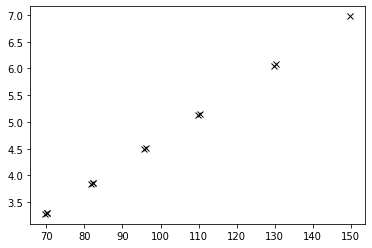

In [163]:
plotting.plot_particle(hits[hits['particle_id']==8.286641868620431e+17])

In [2]:
p = hits[hits['particle_id']== 8.286641868620431e+17]

NameError: name 'hits' is not defined

In [165]:
p

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,pt,nhits,discrete_module_id,Unnamed: 0,unique_layer_id,next_mod_id,connecting_layer_id
5189,39208,1.12280,3.08304,69.750000,3.281130,4,9,74,1.221540,8.286642e+17,0.246616,14,3429,29,19.0,3426.0,19.0
5493,39132,1.12886,3.10050,70.199997,3.299610,4,9,71,1.221625,8.286642e+17,0.246616,14,3426,29,19.0,3432.0,19.0
5542,39255,1.13299,3.10214,70.250000,3.302565,4,9,77,1.220620,8.286642e+17,0.246616,14,3432,29,19.0,3537.0,20.0
8538,41349,1.29761,3.60960,81.750000,3.835753,6,9,74,1.225694,8.286642e+17,0.246616,14,3537,30,20.0,3540.0,20.0
8622,41374,1.30616,3.63071,82.250000,3.858511,6,9,77,1.225459,8.286642e+17,0.246616,14,3540,30,20.0,3534.0,20.0
8624,41276,1.30736,3.63104,82.199997,3.859228,6,9,71,1.225196,8.286642e+17,0.246616,14,3534,30,20.0,3645.0,21.0
10871,43237,1.49038,4.23178,95.750000,4.486557,8,9,74,1.232174,8.286642e+17,0.246616,14,3645,31,21.0,3648.0,21.0
10943,43308,1.50159,4.25197,96.250000,4.509326,8,9,77,1.231317,8.286642e+17,0.246616,14,3648,31,21.0,3753.0,22.0
12965,44882,1.68118,4.84920,109.750000,5.132359,10,9,74,1.237071,8.286642e+17,0.246616,14,3753,34,22.0,3756.0,22.0
13043,44921,1.68900,4.86931,110.250000,5.153921,10,9,77,1.236916,8.286642e+17,0.246616,14,3756,34,22.0,3861.0,23.0


In [134]:
p['z_2'] = p.groupby('particle_id')['z'].shift(-1)

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


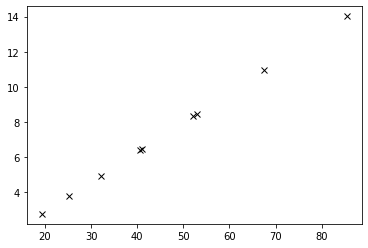

In [89]:
p = hits[hits['particle_id']==-17938.]
plt.plot(p.z, p.r, "kx")

In [90]:
p

,run,lumi,evt,nhit,hit_n,hit_id,x,y,z,particle_id,...,sim_eta,sim_phi,volume_id,layer_id,module_id,r,unique_layer_id,discrete_module_id,z_2,diff_z
4735,1,89,8805,136545,136545,3869,-2.749814,0.362738,19.387152,-17938,...,2.469641,3.00885,2,1,9,2.773636,1,219,25.200001,5.812849
80850,1,89,8805,136545,136545,80456,-3.734851,0.491561,25.200001,-17938,...,2.469641,3.00885,3,17,10,3.767061,33,31710,32.175999,6.975998
84872,1,89,8805,136545,136545,84534,-4.907141,0.641798,32.175999,-17938,...,2.469641,3.00885,3,18,10,4.948933,34,31810,40.699001,8.523003
90534,1,89,8805,136545,136545,90269,-6.350805,0.827724,40.699001,-17938,...,2.469641,3.00885,3,19,16,6.404519,35,31916,41.098999,0.399998
89104,1,89,8805,136545,136545,88819,-6.417197,0.835406,41.098999,-17938,...,2.469641,3.00885,3,19,10,6.471346,35,31910,52.111000,11.012001
94998,1,89,8805,136545,136545,94784,-8.283895,1.070870,52.111000,-17938,...,2.469641,3.00885,3,20,16,8.352824,36,32016,52.910999,0.799999
96180,1,89,8805,136545,136545,95980,-8.415209,1.087709,52.910999,-17938,...,2.469641,3.00885,3,20,12,8.485214,36,32012,67.508003,14.597004
100859,1,89,8805,136545,136545,100701,-10.884128,1.393838,67.508003,-17938,...,2.469641,3.00885,3,21,12,10.973013,37,32112,85.377998,17.869995
106465,1,89,8805,136545,136545,106353,-13.906260,1.759048,85.377998,-17938,...,2.469641,3.00885,3,22,16,14.017072,38,32216,NaN,NaN


In [144]:
np.where(diff > 0)[0]

array([0, 3, 6])

In [138]:
p = p.drop(labels=p.iloc[pos+1].name, axis=0)

In [139]:
p

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,pt,nhits,discrete_module_id,Unnamed: 0,unique_layer_id,next_mod_id,connecting_layer_id,z_2
7250,6391,-2.59016,-2.33594,-81.800003,3.487914,10,7,14,-2.407756,5.855140e+16,0.354168,12,445,27,13.0,440.0,13.0,-81.750000
7332,6334,-2.60499,-2.35309,-82.250000,3.510414,10,7,12,-2.406957,5.855140e+16,0.354168,12,443,27,13.0,337.0,14.0,-95.800003
9404,4413,-3.04598,-2.72336,-95.800003,4.085913,8,7,14,-2.412056,5.855140e+16,0.354168,12,337,24,14.0,332.0,14.0,-95.750000
9405,4323,-3.04830,-2.72123,-95.750000,4.086224,8,7,9,-2.412823,5.855140e+16,0.354168,12,332,24,14.0,335.0,14.0,-96.250000
9492,4371,-3.06163,-2.73652,-96.250000,4.106351,8,7,12,-2.412207,5.855140e+16,0.354168,12,335,24,14.0,229.0,15.0,-109.800003
11505,2726,-3.51320,-3.10103,-109.800003,4.686039,6,7,14,-2.418430,5.855140e+16,0.354168,12,229,23,15.0,224.0,15.0,-109.750000
11510,2644,-3.51488,-3.10098,-109.750000,4.687266,6,7,9,-2.418675,5.855140e+16,0.354168,12,224,23,15.0,227.0,15.0,-110.250000
11571,2670,-3.52904,-3.11601,-110.250000,4.707828,6,7,12,-2.418271,5.855140e+16,0.354168,12,227,23,15.0,121.0,16.0,-129.800003
14136,1314,-4.17919,-3.63444,-129.800003,5.538482,4,7,14,-2.425800,5.855140e+16,0.354168,12,121,22,16.0,119.0,16.0,-130.250000
14202,1278,-4.19692,-3.64697,-130.250000,5.560083,4,7,12,-2.426192,5.855140e+16,0.354168,12,119,22,16.0,11.0,17.0,NaN


In [130]:
-109.75  - (-109.8)

0.04999999999999716

In [158]:
np.where(p.reset_index()['z_2'] < 0)[0] + 1

array([5])

In [150]:
p.reset_index()

,index,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,pt,nhits,discrete_module_id,Unnamed: 0,unique_layer_id,next_mod_id,connecting_layer_id,z_2
0,44191,57520,-3.767270,-25.670300,22.255299,25.945263,2,13,490,-1.716512,4.504012e+15,0.281702,7,5513,7,5.0,5512.0,5.0,21.740000
1,46480,57510,-4.988100,-25.880701,21.740000,26.357006,2,13,489,-1.761196,4.504012e+15,0.281702,7,5512,7,5.0,6486.0,6.0,12.640000
2,51287,62283,-26.461401,-24.301100,12.640000,35.926998,4,13,623,-2.398726,4.504012e+15,0.281702,7,6486,8,6.0,7822.0,7.0,1.140000
3,58356,66988,-49.189499,-9.001630,1.140000,50.006363,6,13,783,-2.960596,4.504012e+15,0.281702,7,7822,9,7.0,7821.0,7.0,0.660000
4,59994,66979,-49.846199,-8.165000,0.660000,50.510506,6,13,782,-2.979231,4.504012e+15,0.281702,7,7821,9,7.0,9588.0,8.0,-16.782499
5,63231,71595,-57.869801,31.402100,-16.782499,65.840759,8,13,911,2.644423,4.504012e+15,0.281702,7,9588,10,8.0,9587.0,8.0,NaN


# Radius estimates

In [48]:
hits.particle_id[100]

3.8281607008957235e+17

In [68]:
low_p = hits[hits['pt'] < 1]
high_p = hits[hits['pt'] > 2]

In [72]:
high_p['particle_id'].iloc[0]

5.719678041949471e+17

In [88]:
len(hits[hits['pt']> 10]['particle_id'])

70

In [85]:
hits[hits['pt']> 10]['particle_id'].iloc[0]

4521604130275328.0

In [86]:
p = hits[hits['particle_id']==4521604130275328.0]

In [57]:
from circle_fit import least_squares_circle

In [87]:
for i in range(len(p)-1): 
    h1 = p.iloc[i]
    h2 = p.iloc[i+1]
    
    xc, yc, R, residu = least_squares_circle([[h1.x, h1.y], [h2.x, h2.y]])
    print(R)

0.12434854814892096
1.8450060666005623
2.290366925739873
2.714868568100889
4.4210063400787805
4.952997053159806
7.166896291544502
7.778334867616047


In [59]:
R

2838.0335152463335

In [42]:
!pip install plotly

     |████████████████████████████████| 15.2 MB 4.2 MB/s eta 0:00:01


In [53]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

fig = go.Figure(data=go.Scatter3d(
    x=p.y, y=p.z, z=p.x,
    marker=dict(
        size=4,
        color=p.z,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.show()

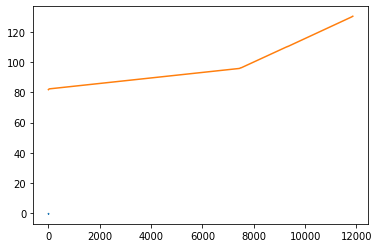

In [36]:


ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');



# Patterns in output

In [172]:
output = pd.read_csv('../evaluation/garage_outputs.csv')

In [173]:
file0 = output.iloc[200:]

In [174]:
par_reward = file0.groupby('particle_id')['reward'].sum()

In [175]:
low_reward = par_reward[par_reward < -10]

In [176]:
np.median(hits[hits['particle_id'].isin(low_reward.index)].pt)

0.47338378

In [177]:
hits['pt'].median()

0.4639576

In [178]:
comb = hits[hits['particle_id'].isin(file0.particle_id)]

In [179]:
file0 = file0.rename(columns={'mc_z': 'z', 'mc_r':'r'})

In [180]:
merged = comb.merge(file0, on=['particle_id', 'z', 'r']).dropna()

In [181]:
merged

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,z_2,diff_z,Unnamed: 0,unique_layer_id,next_mod_id,connecting_layer_id,filenumber,pred_z,pred_r,reward
231,7466,2.364880,2.765070,-81.800003,3.638443,10,7,68,0.863251,6.980656e+17,...,-82.199997,-0.399994,27,13.0,502.0,13.0,0,-81.800003,3.672359,-0.033916
233,6771,2.154000,-2.993470,-81.800003,3.687896,10,7,36,-0.947059,5.269218e+17,...,-82.199997,-0.399994,27,13.0,470.0,13.0,0,-81.750000,3.760045,-0.087782
234,41153,2.396940,2.813220,82.250000,3.695880,6,9,66,0.865126,4.818962e+17,...,95.800003,13.550003,30,20.0,3639.0,21.0,0,82.250000,3.700553,-0.004673
237,7835,-0.764934,3.668090,-81.750000,3.747000,10,7,85,1.776387,4.508135e+15,...,-82.199997,-0.449997,27,13.0,513.0,13.0,0,-81.750000,3.809158,-0.062157
238,7557,0.739935,3.674340,-81.750000,3.748103,10,7,74,1.372075,5.179264e+17,...,-81.800003,-0.050003,27,13.0,510.0,13.0,0,-81.750000,3.725419,-0.022685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,85034,-67.125702,-47.037899,7.600000,81.965988,2,17,1332,-2.530368,3.467835e+17,...,9.760000,2.160000,14,9.0,16631.0,10.0,0,8.680000,81.837029,-1.087672
1862,84249,-55.100700,61.029305,-27.120001,82.223251,2,17,944,2.305187,4.143490e+17,...,-35.760002,-8.640001,14,9.0,16149.0,10.0,0,-25.460001,82.013321,-1.673222
1865,87089,3.201520,-82.252701,107.860001,82.314987,2,17,2431,-1.531893,3.197735e+17,...,121.449997,13.589996,14,9.0,18163.0,43.0,0,62.340004,81.999283,-45.521091
1873,81395,74.055405,-39.389999,-214.750000,83.879524,6,16,42,-0.488840,2.927483e+17,...,-255.550003,-40.800003,51,40.0,11982.0,41.0,0,-179.550003,66.340492,-39.327566


In [182]:
merged.sort_values('reward')['pt']

1807    0.247806
1484    2.234375
1789    0.262993
1798    1.723281
1809    0.458678
          ...   
1385    0.645765
763     1.454185
303     0.350193
795     0.312495
793     0.454151
Name: pt, Length: 1183, dtype: float32

In [183]:
merged['residual_z'] = merged['z'] - merged['pred_z']
merged['residual_r'] = merged['r'] - merged['pred_r']

(array([3.000e+00, 7.000e+00, 5.000e+00, 2.700e+01, 1.031e+03, 6.700e+01,
        2.100e+01, 1.500e+01, 6.000e+00, 1.000e+00]),
 array([-23.73621368, -18.7730464 , -13.80987911,  -8.84671183,
         -3.88354454,   1.07962275,   6.04279003,  11.00595732,
         15.9691246 ,  20.93229189,  25.89545918]),
 <BarContainer object of 10 artists>)

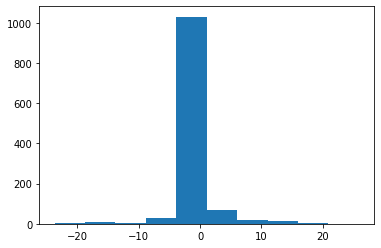

In [184]:
plt.hist(merged['residual_r'])

(array([1.000e+00, 0.000e+00, 2.000e+00, 1.800e+01, 2.300e+01, 1.019e+03,
        8.600e+01, 1.700e+01, 1.200e+01, 5.000e+00]),
 array([-113.37000275,  -93.46800308,  -73.56600342,  -53.66400375,
         -33.76200409,  -13.86000443,    6.04199524,   25.9439949 ,
          45.84599457,   65.74799423,   85.6499939 ]),
 <BarContainer object of 10 artists>)

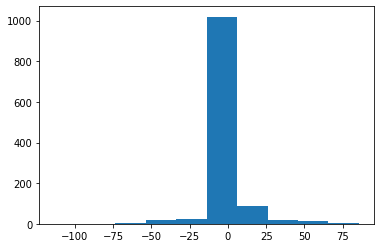

In [185]:
plt.hist(merged['residual_z'])

In [186]:
perfect = merged[merged['reward']==10]

In [191]:
awful = merged[merged['reward']< -20]

In [192]:
awful

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,Unnamed: 0,unique_layer_id,next_mod_id,connecting_layer_id,filenumber,pred_z,pred_r,reward,residual_z,residual_r
1121,46053,17.394001,1.512430,130.199997,17.459629,12,9,56,0.086733,3.197703e+17,...,33,23.0,11415.0,34.0,0,179.550003,24.306835,-49.822759,-49.350006,-6.847206
1126,52440,24.229801,-0.151419,-149.550003,24.230274,10,12,86,-0.006249,1.621312e+17,...,41,26.0,4766.0,26.0,0,-110.199997,17.265354,-39.961645,-39.350006,6.964920
1127,77379,12.871800,20.618900,179.550003,24.306835,6,14,112,1.012721,4.053287e+17,...,44,33.0,11441.0,34.0,0,129.800003,15.957936,-50.445680,49.750000,8.348899
1128,52972,-24.182100,2.730690,-149.550003,24.335789,10,12,168,3.029147,6.530265e+17,...,41,26.0,4848.0,26.0,0,-109.800003,15.649282,-40.688056,-39.750000,8.686506
1129,52947,-24.196899,2.710920,-149.850006,24.348286,10,12,165,3.030022,6.530265e+17,...,41,26.0,4681.0,27.0,0,-129.800003,17.541908,-21.173790,-20.050003,6.806377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,86382,8.265631,81.473404,61.259998,81.891609,2,17,2009,1.469690,1.441157e+17,...,14,9.0,14435.0,9.0,0,40.660000,82.209717,-20.602455,20.599998,-0.318108
1841,85489,-81.496506,8.166281,17.900000,81.904625,2,17,1559,3.041722,7.971387e+17,...,14,9.0,13985.0,9.0,0,46.639999,81.634232,-28.741272,-28.740000,0.270393
1843,86286,21.635300,-79.002602,58.020000,81.911514,2,17,1956,-1.303494,5.719666e+17,...,14,9.0,14382.0,9.0,0,22.219999,81.953995,-35.800030,35.800001,-0.042480
1865,87089,3.201520,-82.252701,107.860001,82.314987,2,17,2431,-1.531893,3.197735e+17,...,14,9.0,18163.0,43.0,0,62.340004,81.999283,-45.521091,45.519997,0.315704


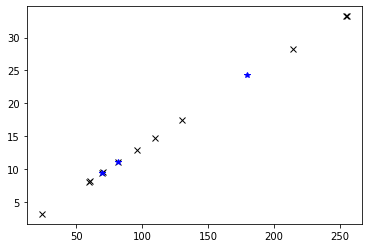

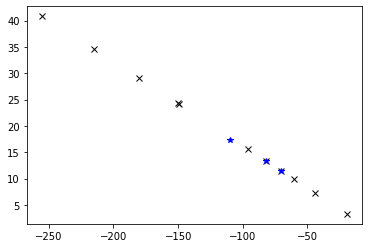

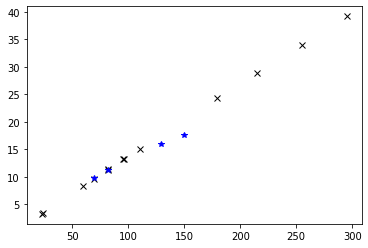

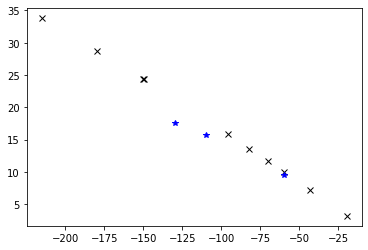

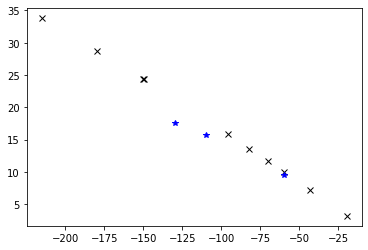

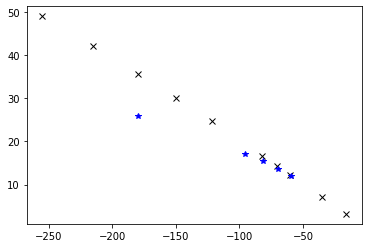

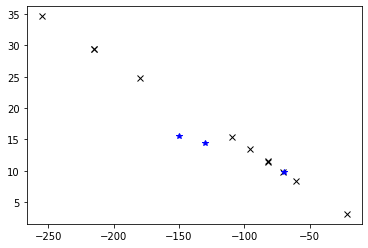

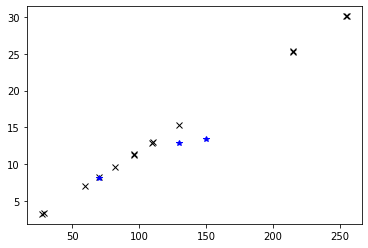

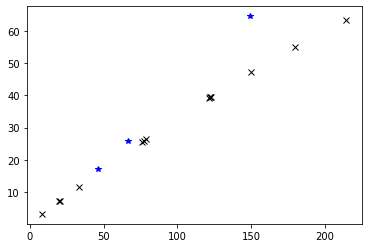

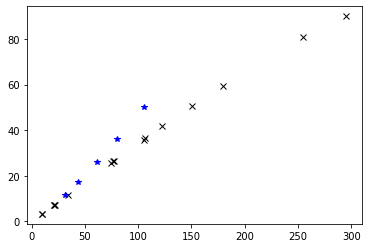

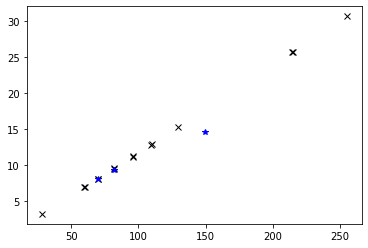

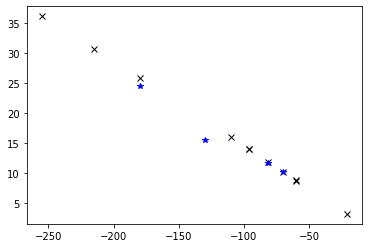

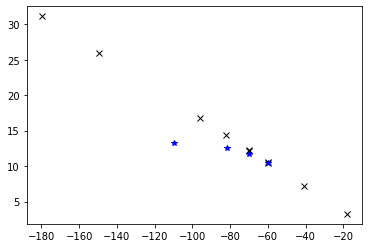

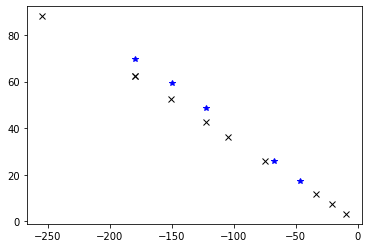

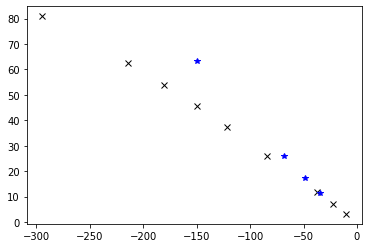

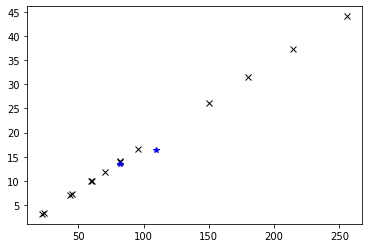

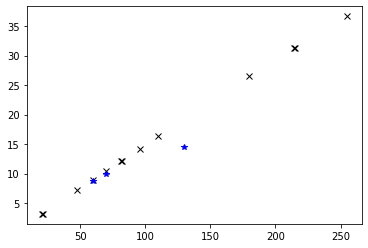

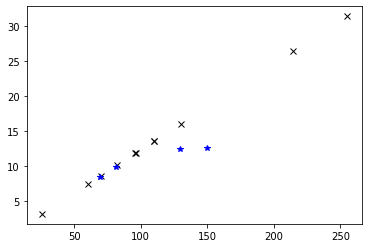

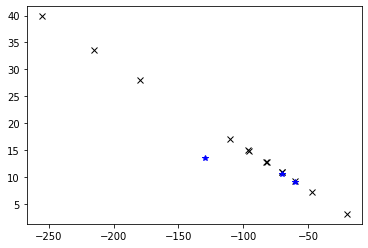

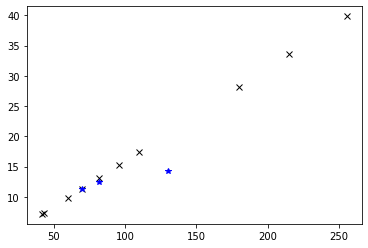

In [193]:
for pid in awful.particle_id[:20]: 
    p = hits[hits['particle_id']==pid]
    p_m = merged[merged['particle_id']==pid]
    plt.plot(p.z, p.r, "kx")
    plt.plot(p_m.pred_z, p_m.pred_r, "b*")
    plt.show() 

In [49]:
!readlink -f new_allowed_pids

/home/lhv14/DDPG/notebooks/new_allowed_pids


In [50]:
!ls

'Algo fitting-CMS.ipynb'   new_allowed_pids.npz        Untitled.ipynb
'Algo fitting.ipynb'	  'NN control.ipynb'
'Evaluation plots.ipynb'  'Quality monitoring.ipynb'


In [58]:
y = np.loadtxt('new_allowed_pids.out')

In [59]:
y

array([-17938., -17935., -17934., ...,    907.,    908.,    909.])

In [56]:
!ls

'Algo fitting-CMS.ipynb'   new_allowed_pids	 'Quality monitoring.ipynb'
'Algo fitting.ipynb'	   new_allowed_pids.npz   Untitled.ipynb
'Evaluation plots.ipynb'  'NN control.ipynb'
